# Analisi Variabili Testuali - Questionario sul Medioevo

Questo notebook analizza le variabili **categoriche non mappabili** (risposte testuali):
- **Date di inizio e fine medioevo** → Clustering
- **Motivazioni delle date** → Analisi tematica
- **Commento aperto finale** → NLP (Natural Language Processing)

**Contenuti:**
1. Load & Preprocessing
2. Analisi Generale
   - 2.1 Analisi e Clustering delle Date
   - 2.2 Analisi delle Motivazioni
   - 2.3 Analisi delle Risposte Aperte
3. Analisi per Titolo di Studio e Corso di Storia
4. Analisi per Sesso
5. Analisi per Fascia d'Età
6. Analisi per Metodo Informativo

## 1. Load & Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Impostazioni grafiche
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Caricamento dati
df = pd.read_csv('risposte.csv')

print(f"Dimensioni dataset: {df.shape[0]} righe x {df.shape[1]} colonne")
print(f"\nColonne disponibili:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

Dimensioni dataset: 349 righe x 45 colonne

Colonne disponibili:
1. Informazioni cronologiche
2. Sesso
3. Quanti anni compi nell'anno corrente 2025?
4. Qual è l'ultimo titolo di studi che hai conseguito?
5. Hai mai frequentato un corso universitario o accademico che trattava anche solo in parte di storia medievale?
6. Regione
7. Provincia (sigla)
8. Con quali modalità ti informi sul medioevo?
9. Qual è la tua opinione generale sul medioevo? [Medioevo]
10. Indica la data o il secolo in cui secondo te inizia il medioevo
11. Perché? Inizio
12. Indica la data o il secolo in cui secondo te finisce il medioevo
13. Perché?  Fine
14.  [Feudalesimo]
15. [Superstizione]
16. [Germanico]
17. [Eroico]
18. [Comunale]
19. [Sperimentazione]
20. [Cristiano]
21. [Oscurantismo]
22. [Rinascita]
23. [Decadenza]
24. Quali di questi termini associ più fortemente con la tua idea di medioevo? (Max 5 risposte)
25. [Federico II di Svevia]
26. [Teodorico]
27. [Lorenzo il Magnifico]
28. [Costantino]
29. [Petrarca]

In [2]:
# Rinomina colonne per facilità d'uso (stesso mapping del notebook analisi_dati)
column_mapping = {
    'Informazioni cronologiche': 'timestamp',
    'Sesso': 'sesso',
    'Quanti anni compi nell\'anno corrente 2025?': 'eta',
    'Qual è l\'ultimo titolo di studi che hai conseguito?': 'titolo_studio',
    'Hai mai frequentato un corso universitario o accademico che trattava anche solo in parte di storia medievale?': 'corso_medievale',
    'Regione': 'regione',
    'Provincia (sigla)': 'provincia',
    'Con quali modalità ti informi sul medioevo?': 'modalita_info',
    'Qual è la tua opinione generale sul medioevo? [Medioevo]': 'opinione_medioevo',
    'Indica la data o il secolo in cui secondo te inizia il medioevo': 'data_inizio',
    'Perché? Inizio': 'perche_inizio',
    'Indica la data o il secolo in cui secondo te finisce il medioevo': 'data_fine',
    'Perché?  Fine': 'perche_fine',
    'Quali di questi termini associ più fortemente con la tua idea di medioevo? (Max 5 risposte)': 'termini_associati',
    'Se volessi aggiungere un tuo commento facoltativo su cosa pensi sia il medioevo': 'commento_aperto',
    ' [Feudalesimo]': 'feudalesimo',
    '[Superstizione]': 'superstizione',
    '[Germanico]': 'germanico',
    '[Eroico]': 'eroico',
    '[Comunale]': 'comunale',
    '[Sperimentazione]': 'sperimentazione',
    '[Cristiano]': 'cristiano',
    '[Oscurantismo]': 'oscurantismo',
    '[Rinascita]': 'rinascita',
    '[Decadenza]': 'decadenza'
}

# Applica il mapping dove possibile
for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

# Pulizia nomi colonne
df.columns = df.columns.str.strip()

print("Colonne rinominate con successo!")
print(f"\nValori mancanti per colonna:")
missing = df.isnull().sum()
print(missing[missing > 0] if len(missing[missing > 0]) > 0 else "Nessun valore mancante")

Colonne rinominate con successo!

Valori mancanti per colonna:
perche_inizio       68
perche_fine         61
commento_aperto    192
dtype: int64


In [3]:
# Rimuovi duplicati
duplicati_prima = len(df)
df = df.drop_duplicates()
duplicati_dopo = len(df)
print(f"Righe rimosse come duplicati: {duplicati_prima - duplicati_dopo}")

# Standardizza la provincia (uppercase)
if 'provincia' in df.columns:
    df['provincia'] = df['provincia'].str.upper().str.strip()

print(f"\nDataset finale: {len(df)} risposte")

print(f"\n📝 Variabili testuali da analizzare:")
text_cols = ['data_inizio', 'perche_inizio', 'data_fine', 'perche_fine', 'termini_associati', 'commento_aperto']
for col in text_cols:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"   • {col}: {non_null} risposte ({non_null/len(df)*100:.1f}%)")

Righe rimosse come duplicati: 0

Dataset finale: 349 risposte

📝 Variabili testuali da analizzare:
   • data_inizio: 349 risposte (100.0%)
   • perche_inizio: 281 risposte (80.5%)
   • data_fine: 349 risposte (100.0%)
   • perche_fine: 288 risposte (82.5%)
   • termini_associati: 349 risposte (100.0%)
   • commento_aperto: 157 risposte (45.0%)


In [4]:
# Conversioni numeriche (stesso del notebook analisi_dati)
# per poter correlare con le variabili demografiche

# ---- SESSO ----
sesso_map = {'Uomo': 1, 'Donna': 2, 'Non-binario': 3, 'Preferisco non rispondere': 4}
if 'sesso' in df.columns:
    df['sesso_num'] = df['sesso'].map(sesso_map)
    print("SESSO - Mapping:")
    for k, v in sesso_map.items():
        print(f"  {k} -> {v}")

# ---- ETÀ ----
eta_map = {
    '18-19': 18.5,
    '20-29': 24.5,
    '30-39': 34.5,
    '40-49': 44.5,
    '50-59': 54.5,
    '60-69': 64.5,
    '70+': 75
}
if 'eta' in df.columns:
    df['eta_num'] = df['eta'].map(eta_map)
    print("\nETÀ - Mapping (punto medio):")
    for k, v in eta_map.items():
        print(f"  {k} -> {v}")

# ---- TITOLO DI STUDIO ----
titolo_map = {
    'Licenza elementare': 1,
    'Licenza media': 2,
    'Diploma di istruzione professionale': 3,
    'Diploma di istruzione tecnica': 4,
    'Diploma di istruzione liceale': 5,
    'Laurea triennale': 6,
    'Laurea magistrale': 7,
    'Dottorato': 8
}
if 'titolo_studio' in df.columns:
    df['titolo_studio_num'] = df['titolo_studio'].map(titolo_map)
    print("\nTITOLO DI STUDIO - Mapping (ordinale):")
    for k, v in titolo_map.items():
        print(f"  {k} -> {v}")

# ---- OPINIONE MEDIOEVO ----
opinione_map = {
    'Assolutamente negativa': 1,
    'Parzialmente negativa': 2,
    'Neutrale': 3,
    'Parzialmente positiva': 4,
    'Assolutamente positiva': 5
}
if 'opinione_medioevo' in df.columns:
    df['opinione_num'] = df['opinione_medioevo'].map(opinione_map)
    print("\nOPINIONE MEDIOEVO - Mapping:")
    for k, v in opinione_map.items():
        print(f"  {k} -> {v}")

# ---- CORSO MEDIEVALE ----
corso_map = {'Sì': 1, 'No': 0}
if 'corso_medievale' in df.columns:
    df['corso_num'] = df['corso_medievale'].map(corso_map)
    print("\nCORSO MEDIEVALE - Mapping:")
    for k, v in corso_map.items():
        print(f"  {k} -> {v}")

print(f"\n✅ Variabili numeriche create per correlazioni:")
print(f"   • eta_num: media {df['eta_num'].mean():.1f}")
print(f"   • titolo_studio_num: media {df['titolo_studio_num'].mean():.1f}")
print(f"   • opinione_num: media {df['opinione_num'].mean():.2f}")
print(f"   • corso_num: {df['corso_num'].sum():.0f} hanno frequentato corsi")

SESSO - Mapping:
  Uomo -> 1
  Donna -> 2
  Non-binario -> 3
  Preferisco non rispondere -> 4

ETÀ - Mapping (punto medio):
  18-19 -> 18.5
  20-29 -> 24.5
  30-39 -> 34.5
  40-49 -> 44.5
  50-59 -> 54.5
  60-69 -> 64.5
  70+ -> 75

TITOLO DI STUDIO - Mapping (ordinale):
  Licenza elementare -> 1
  Licenza media -> 2
  Diploma di istruzione professionale -> 3
  Diploma di istruzione tecnica -> 4
  Diploma di istruzione liceale -> 5
  Laurea triennale -> 6
  Laurea magistrale -> 7
  Dottorato -> 8

OPINIONE MEDIOEVO - Mapping:
  Assolutamente negativa -> 1
  Parzialmente negativa -> 2
  Neutrale -> 3
  Parzialmente positiva -> 4
  Assolutamente positiva -> 5

CORSO MEDIEVALE - Mapping:
  Sì -> 1
  No -> 0

✅ Variabili numeriche create per correlazioni:
   • eta_num: media 38.2
   • titolo_studio_num: media 5.2
   • opinione_num: media 2.98
   • corso_num: 83 hanno frequentato corsi


## 2. Analisi Generale



### 2.1 Analisi e Clustering delle Date (Inizio/Fine Medioevo)

In [5]:
def estrai_anno(testo):
    """
    Estrae un anno numerico da una risposta testuale.
    Gestisce formati come: '476', '476 d.C.', 'V secolo', '1492', etc.
    """
    if pd.isna(testo):
        return None
    
    testo = str(testo).lower().strip()
    
    # Mapping secoli romani -> anno medio
    secoli_romani = {
        'i': 50, 'ii': 150, 'iii': 250, 'iv': 350, 'v': 450,
        'vi': 550, 'vii': 650, 'viii': 750, 'ix': 850, 'x': 950,
        'xi': 1050, 'xii': 1150, 'xiii': 1250, 'xiv': 1350, 'xv': 1450,
        'xvi': 1550, 'xvii': 1650, 'xviii': 1750
    }
    
    # Pattern per secoli romani (es. "V secolo", "XV sec")
    match_romano = re.search(r'\b(i{1,3}|iv|vi{0,3}|ix|xi{0,3}|xiv|xv|xvi{0,3})\b\s*(secolo|sec\.?|°)', testo)
    if match_romano:
        secolo = match_romano.group(1)
        if secolo in secoli_romani:
            return secoli_romani[secolo]
    
    # Pattern per anni espliciti (es. "476", "1492", "476 d.c.")
    match_anno = re.search(r'\b(\d{3,4})\b', testo)
    if match_anno:
        anno = int(match_anno.group(1))
        # Correggi anni < 100 che probabilmente sono secoli
        if anno < 100:
            return anno * 100 + 50
        return anno
    
    # Pattern per secoli con numero (es. "5° secolo", "XV secolo")
    match_num_sec = re.search(r'(\d{1,2})\s*(°|º)?\s*(secolo|sec)', testo)
    if match_num_sec:
        secolo = int(match_num_sec.group(1))
        return secolo * 100 - 50
    
    # Pattern "dopo il" con numero
    match_dopo = re.search(r'dopo\s+(?:il\s+)?(\d{3,4})', testo)
    if match_dopo:
        return int(match_dopo.group(1))
    
    return None

# Estrai anni dalle risposte
df['anno_inizio'] = df['data_inizio'].apply(estrai_anno)
df['anno_fine'] = df['data_fine'].apply(estrai_anno)

# Statistiche
print("=" * 60)
print("📅 ESTRAZIONE DATE")
print("=" * 60)

for col, label in [('anno_inizio', 'Inizio Medioevo'), ('anno_fine', 'Fine Medioevo')]:
    valid = df[col].dropna()
    print(f"\n{label}:")
    print(f"   Risposte valide estratte: {len(valid)} ({len(valid)/len(df)*100:.1f}%)")
    if len(valid) > 0:
        print(f"   Media: {valid.mean():.0f}")
        print(f"   Mediana: {valid.median():.0f}")
        print(f"   Min: {valid.min():.0f}, Max: {valid.max():.0f}")

📅 ESTRAZIONE DATE

Inizio Medioevo:
   Risposte valide estratte: 315 (90.3%)
   Media: 607
   Mediana: 476
   Min: 50, Max: 1800

Fine Medioevo:
   Risposte valide estratte: 322 (92.3%)
   Media: 1462
   Mediana: 1492
   Min: 500, Max: 1942


In [6]:
# Clustering manuale basato su periodi storici significativi

def cluster_data_inizio(anno):
    """Classifica la data di inizio in cluster storici"""
    if pd.isna(anno):
        return 'Non specificato'
    if anno < 400:
        return 'Pre-400'
    elif anno <= 500:
        return '476-500 (Caduta Impero Romano Occ.)'
    elif anno <= 600:
        return '500-600 (Alto Medioevo)'
    elif anno <= 800:
        return '600-800 (Periodo pre-carolingio)'
    elif anno <= 1000:
        return '800-1000 (Impero Carolingio)'
    else:
        return '1000+ (Basso Medioevo)'

def cluster_data_fine(anno):
    """Classifica la data di fine in cluster storici"""
    if pd.isna(anno):
        return 'Non specificato'
    if anno < 1000:
        return 'Pre-1000 (Fine anticipata)'
    elif anno <= 1400:
        return '1000-1400 (Fine anticipata)'
    elif anno <= 1453:
        return '1400-1453 (Caduta Costantinopoli)'
    elif anno <= 1492:
        return '1454-1492 (Scoperta America)'
    elif anno <= 1517:
        return '1493-1517 (Riforma protestante)'
    else:
        return '1518+ (Fine posticipata)'

df['cluster_inizio'] = df['anno_inizio'].apply(cluster_data_inizio)
df['cluster_fine'] = df['anno_fine'].apply(cluster_data_fine)

# Distribuzione dei cluster
print("=" * 60)
print("📊 CLUSTERING DATE")
print("=" * 60)

print("\n🔹 CLUSTER DATA INIZIO MEDIOEVO:")
cluster_inizio_counts = df['cluster_inizio'].value_counts()
for cluster, count in cluster_inizio_counts.items():
    print(f"   {cluster}: {count} ({count/len(df)*100:.1f}%)")

print("\n🔹 CLUSTER DATA FINE MEDIOEVO:")
cluster_fine_counts = df['cluster_fine'].value_counts()
for cluster, count in cluster_fine_counts.items():
    print(f"   {cluster}: {count} ({count/len(df)*100:.1f}%)")

📊 CLUSTERING DATE

🔹 CLUSTER DATA INIZIO MEDIOEVO:
   476-500 (Caduta Impero Romano Occ.): 215 (61.6%)
   Non specificato: 34 (9.7%)
   1000+ (Basso Medioevo): 31 (8.9%)
   800-1000 (Impero Carolingio): 30 (8.6%)
   Pre-400: 15 (4.3%)
   600-800 (Periodo pre-carolingio): 15 (4.3%)
   500-600 (Alto Medioevo): 9 (2.6%)

🔹 CLUSTER DATA FINE MEDIOEVO:
   1454-1492 (Scoperta America): 177 (50.7%)
   1000-1400 (Fine anticipata): 52 (14.9%)
   1400-1453 (Caduta Costantinopoli): 29 (8.3%)
   1493-1517 (Riforma protestante): 29 (8.3%)
   1518+ (Fine posticipata): 29 (8.3%)
   Non specificato: 27 (7.7%)
   Pre-1000 (Fine anticipata): 6 (1.7%)


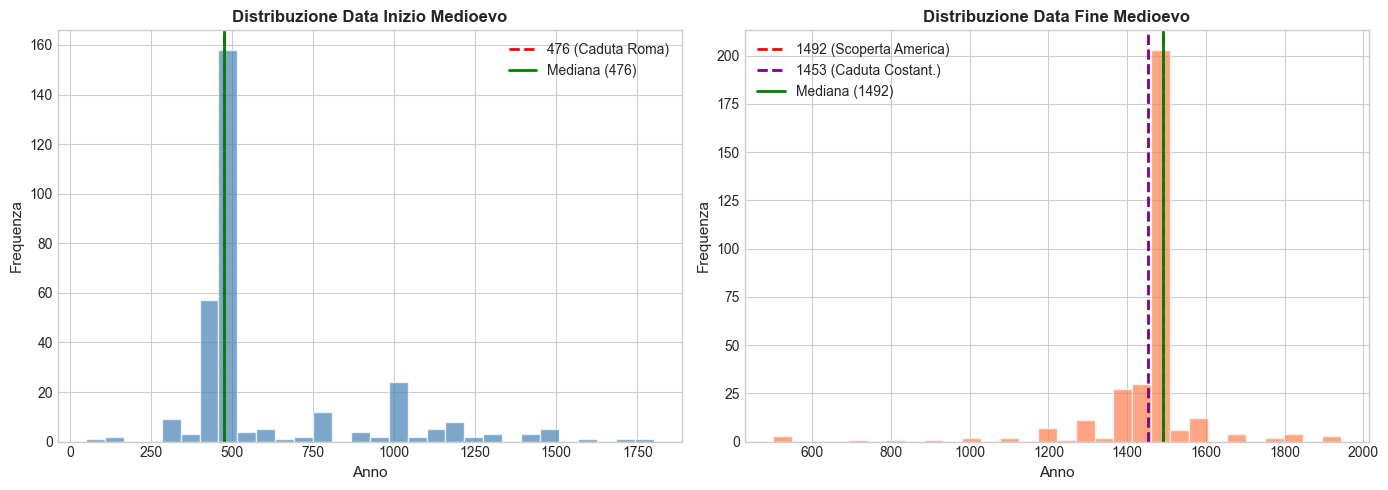


📏 DURATA MEDIOEVO PERCEPITA:
   Media: 864 anni
   Mediana: 1016 anni
   Min: 100, Max: 1466


In [7]:
# Visualizzazione distribuzione date
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma anno inizio
ax1 = axes[0]
valid_inizio = df['anno_inizio'].dropna()
ax1.hist(valid_inizio, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(x=476, color='red', linestyle='--', linewidth=2, label='476 (Caduta Roma)')
ax1.axvline(x=valid_inizio.median(), color='green', linestyle='-', linewidth=2, label=f'Mediana ({valid_inizio.median():.0f})')
ax1.set_xlabel('Anno', fontsize=11)
ax1.set_ylabel('Frequenza', fontsize=11)
ax1.set_title('Distribuzione Data Inizio Medioevo', fontsize=12, fontweight='bold')
ax1.legend()

# Istogramma anno fine
ax2 = axes[1]
valid_fine = df['anno_fine'].dropna()
ax2.hist(valid_fine, bins=30, color='coral', edgecolor='white', alpha=0.7)
ax2.axvline(x=1492, color='red', linestyle='--', linewidth=2, label='1492 (Scoperta America)')
ax2.axvline(x=1453, color='purple', linestyle='--', linewidth=2, label='1453 (Caduta Costant.)')
ax2.axvline(x=valid_fine.median(), color='green', linestyle='-', linewidth=2, label=f'Mediana ({valid_fine.median():.0f})')
ax2.set_xlabel('Anno', fontsize=11)
ax2.set_ylabel('Frequenza', fontsize=11)
ax2.set_title('Distribuzione Data Fine Medioevo', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

# Calcola durata medioevo percepita
df['durata_medioevo'] = df['anno_fine'] - df['anno_inizio']
valid_durata = df['durata_medioevo'].dropna()
valid_durata = valid_durata[(valid_durata > 0) & (valid_durata < 2000)]  # Filtra valori anomali

print(f"\n📏 DURATA MEDIOEVO PERCEPITA:")
print(f"   Media: {valid_durata.mean():.0f} anni")
print(f"   Mediana: {valid_durata.median():.0f} anni")
print(f"   Min: {valid_durata.min():.0f}, Max: {valid_durata.max():.0f}")

In [8]:
# Correlazione date con variabili demografiche
print("=" * 60)
print("📈 CORRELAZIONI DATE - VARIABILI DEMOGRAFICHE")
print("=" * 60)

# Prepara dati per correlazione
df_corr = df[['anno_inizio', 'anno_fine', 'durata_medioevo', 
              'eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num']].dropna()

if len(df_corr) > 10:
    correlazioni = df_corr.corr()
    
    print("\n🔹 Data Inizio correlata con:")
    for var in ['eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num']:
        r = correlazioni.loc['anno_inizio', var]
        significato = "→ nessuna relazione" if abs(r) < 0.1 else ("→ relazione debole" if abs(r) < 0.3 else "→ relazione moderata")
        print(f"   {var}: r = {r:.3f} {significato}")
    
    print("\n🔹 Data Fine correlata con:")
    for var in ['eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num']:
        r = correlazioni.loc['anno_fine', var]
        significato = "→ nessuna relazione" if abs(r) < 0.1 else ("→ relazione debole" if abs(r) < 0.3 else "→ relazione moderata")
        print(f"   {var}: r = {r:.3f} {significato}")

# Analisi per gruppo
print("\n" + "=" * 60)
print("📊 ANALISI PER GRUPPI")
print("=" * 60)

# Per titolo di studio
print("\n🎓 Anno inizio medio per TITOLO DI STUDIO:")
for titolo in df['titolo_studio'].dropna().unique():
    subset = df[df['titolo_studio'] == titolo]['anno_inizio'].dropna()
    if len(subset) > 5:
        print(f"   {titolo[:40]}: {subset.mean():.0f} (n={len(subset)})")

# Per fascia d'età
print("\n👤 Anno inizio medio per FASCIA D'ETÀ:")
for eta in sorted(df['eta'].dropna().unique()):
    subset = df[df['eta'] == eta]['anno_inizio'].dropna()
    if len(subset) > 3:
        print(f"   {eta}: {subset.mean():.0f} (n={len(subset)})")

📈 CORRELAZIONI DATE - VARIABILI DEMOGRAFICHE

🔹 Data Inizio correlata con:
   eta_num: r = 0.071 → nessuna relazione
   titolo_studio_num: r = -0.096 → nessuna relazione
   opinione_num: r = 0.008 → nessuna relazione
   corso_num: r = -0.129 → relazione debole

🔹 Data Fine correlata con:
   eta_num: r = -0.025 → nessuna relazione
   titolo_studio_num: r = 0.067 → nessuna relazione
   opinione_num: r = -0.036 → nessuna relazione
   corso_num: r = 0.036 → nessuna relazione

📊 ANALISI PER GRUPPI

🎓 Anno inizio medio per TITOLO DI STUDIO:
   Diploma di istruzione liceale: 539 (n=68)
   Licenza media: 682 (n=29)
   Laurea triennale: 601 (n=72)
   Diploma di istruzione tecnica: 651 (n=51)
   Laurea magistrale: 602 (n=69)
   Diploma di istruzione professionale: 701 (n=21)

👤 Anno inizio medio per FASCIA D'ETÀ:
   18-19: 659 (n=15)
   20-29: 547 (n=133)
   30-39: 698 (n=38)
   40-49: 658 (n=30)
   50-59: 638 (n=59)
   60-69: 563 (n=32)
   70-79: 838 (n=6)


### 2.2 Analisi delle Motivazioni (Perché inizio/fine)

In [9]:
# Analisi tematica delle motivazioni per inizio/fine medioevo

motivazioni_inizio = {
    'Caduta Roma': ['caduta', 'roma', 'romano', 'impero', 'occidente', '476', 'romolo', 'augustolo', 'odoacre'],
    'Carlo Magno': ['carlo', 'magno', 'carolingio', 'incoronazione', '800'],
    'Costantino': ['costantino', 'editto', 'milano', '313', 'cristiano'],
    'Invasioni barbariche': ['barbari', 'barbariche', 'invasioni', 'germani'],
    'Ricordi scolastici': ['scuola', 'ricordo', 'studiato', 'lezione', 'memoria']
}

motivazioni_fine = {
    'Scoperta America': ['america', 'colombo', 'scoperta', '1492', 'americhe', 'nuovo mondo'],
    'Caduta Costantinopoli': ['costantinopoli', '1453', 'bisanzio', 'oriente', 'turchi'],
    'Riforma protestante': ['riforma', 'lutero', 'protestante', '1517'],
    'Rinascimento': ['rinascimento', 'umanesimo', 'cultura'],
    'Stampa': ['stampa', 'gutenberg', 'invenzione'],
    'Ricordi scolastici': ['scuola', 'ricordo', 'studiato', 'lezione', 'memoria', 'convenzional']
}

def classifica_motivazione(testo, motivazioni_dict):
    """Classifica la motivazione in categorie"""
    if pd.isna(testo):
        return 'Non specificato'
    testo = str(testo).lower()
    for motivo, keywords in motivazioni_dict.items():
        if any(kw in testo for kw in keywords):
            return motivo
    return 'Altro'

df['motivo_inizio_cat'] = df['perche_inizio'].apply(lambda x: classifica_motivazione(x, motivazioni_inizio))
df['motivo_fine_cat'] = df['perche_fine'].apply(lambda x: classifica_motivazione(x, motivazioni_fine))

print("=" * 60)
print("📖 MOTIVAZIONI SCELTA DATE")
print("=" * 60)

print("\n🔹 MOTIVAZIONI INIZIO MEDIOEVO:")
motivo_inizio_counts = df['motivo_inizio_cat'].value_counts()
for motivo, count in motivo_inizio_counts.items():
    pct = count / len(df) * 100
    print(f"   {motivo}: {count} ({pct:.1f}%)")

print("\n🔹 MOTIVAZIONI FINE MEDIOEVO:")
motivo_fine_counts = df['motivo_fine_cat'].value_counts()
for motivo, count in motivo_fine_counts.items():
    pct = count / len(df) * 100
    print(f"   {motivo}: {count} ({pct:.1f}%)")

📖 MOTIVAZIONI SCELTA DATE

🔹 MOTIVAZIONI INIZIO MEDIOEVO:
   Caduta Roma: 203 (58.2%)
   Non specificato: 68 (19.5%)
   Altro: 52 (14.9%)
   Ricordi scolastici: 18 (5.2%)
   Carlo Magno: 3 (0.9%)
   Invasioni barbariche: 3 (0.9%)
   Costantino: 2 (0.6%)

🔹 MOTIVAZIONI FINE MEDIOEVO:
   Scoperta America: 194 (55.6%)
   Non specificato: 61 (17.5%)
   Altro: 49 (14.0%)
   Rinascimento: 23 (6.6%)
   Ricordi scolastici: 13 (3.7%)
   Caduta Costantinopoli: 7 (2.0%)
   Riforma protestante: 2 (0.6%)


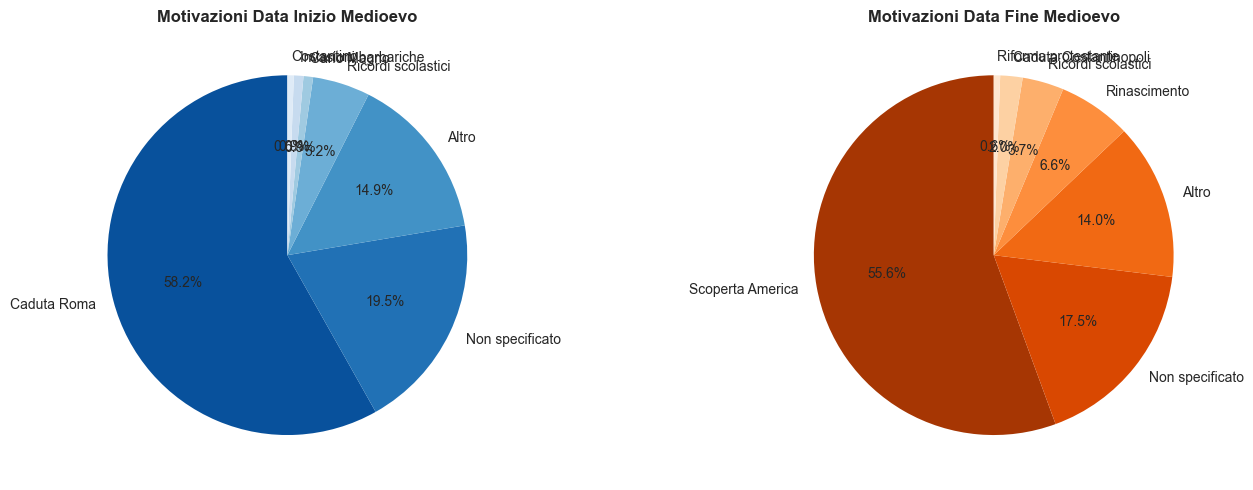

In [10]:
# Visualizzazione motivazioni
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Motivazioni inizio
ax1 = axes[0]
motivo_inizio = df['motivo_inizio_cat'].value_counts()
colors1 = sns.color_palette("Blues_r", len(motivo_inizio))
ax1.pie(motivo_inizio.values, labels=motivo_inizio.index, autopct='%1.1f%%',
        colors=colors1, startangle=90)
ax1.set_title('Motivazioni Data Inizio Medioevo', fontsize=12, fontweight='bold')

# Motivazioni fine
ax2 = axes[1]
motivo_fine = df['motivo_fine_cat'].value_counts()
colors2 = sns.color_palette("Oranges_r", len(motivo_fine))
ax2.pie(motivo_fine.values, labels=motivo_fine.index, autopct='%1.1f%%',
        colors=colors2, startangle=90)
ax2.set_title('Motivazioni Data Fine Medioevo', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

🔍 COERENZA TRA DATA E MOTIVAZIONE

🔹 INIZIO MEDIOEVO (data corretta = 476-500, motivazione corretta = Caduta Roma)
   Totale rispondenti: 349

   ✅ Data corretta E motivazione corretta:      170 ( 48.7%)
   🟡 Solo data corretta (motivazione errata):     45 ( 12.9%)
       ↳ di cui nessuna motivazione fornita:       21
       ↳ di cui motivazione diversa fornita:       24
   🟡 Solo motivazione corretta (data errata):     33 (  9.5%)
       ↳ di cui nessuna data fornita:              12
       ↳ di cui data diversa fornita:              21
   ❌ Né data né motivazione corretta:            101 ( 28.9%)


🔹 FINE MEDIOEVO (date corrette = 1400-1492, motivazioni = Scoperta America / Caduta Costantinopoli)
   Totale rispondenti: 349

   ✅ Data E motivazione corretta (coerenti):    166 ( 47.6%)
   🔄 Data + motivazione corrette ma incoerenti:   11 (  3.2%)
      (es. data 1492 ma motivazione 'Caduta Costantinopoli')
   🟡 Solo data corretta (motivazione errata):     29 (  8.3%)
       ↳ di cui ne

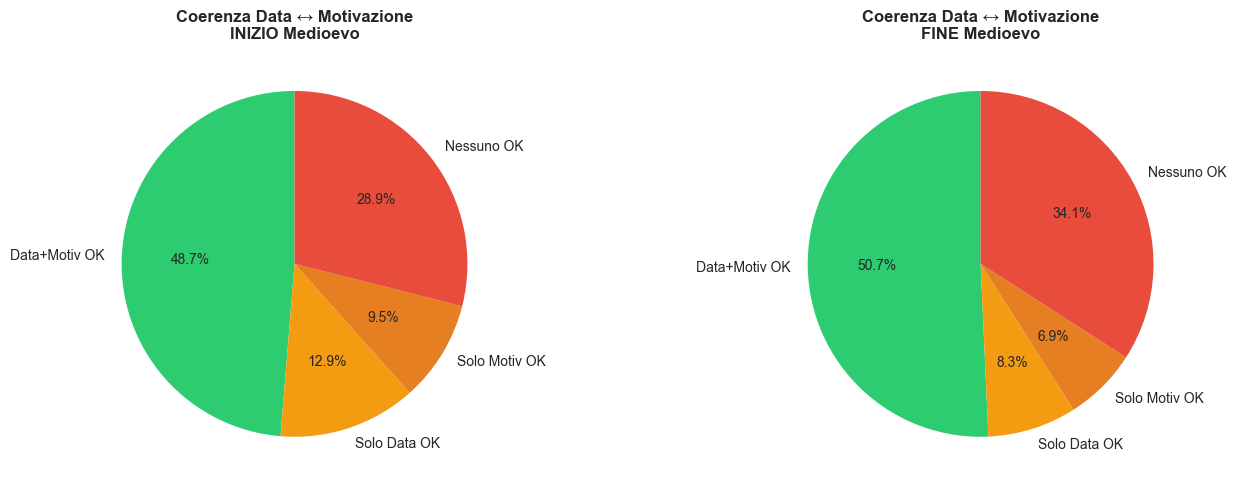

In [11]:
# ============================================================
# CHECK COERENZA DATA ↔ MOTIVAZIONE
# ============================================================
# "Corretta" per inizio = cluster 476-500 + motivazione "Caduta Roma"
# "Corretta" per fine   = cluster 1454-1492 + motivazione "Scoperta America"
#                       OPPURE cluster 1400-1453 + motivazione "Caduta Costantinopoli"

print("=" * 70)
print("🔍 COERENZA TRA DATA E MOTIVAZIONE")
print("=" * 70)

# ------- INIZIO MEDIOEVO -------
data_corretta_inizio = df['cluster_inizio'] == '476-500 (Caduta Impero Romano Occ.)'
motivo_corretto_inizio = df['motivo_inizio_cat'] == 'Caduta Roma'
motivo_dato_inizio = df['motivo_inizio_cat'] != 'Non specificato'

# Combinazioni
entrambi_ok_inizio   = (data_corretta_inizio & motivo_corretto_inizio).sum()
solo_data_inizio     = (data_corretta_inizio & ~motivo_corretto_inizio).sum()
solo_motivo_inizio   = (~data_corretta_inizio & motivo_corretto_inizio).sum()
nessuno_inizio       = (~data_corretta_inizio & ~motivo_corretto_inizio).sum()

# Di chi ha la data giusta ma motivazione sbagliata: quanti non hanno risposto vs hanno risposto altro
solo_data_no_motivo  = (data_corretta_inizio & (df['motivo_inizio_cat'] == 'Non specificato')).sum()
solo_data_motivo_err = (data_corretta_inizio & ~motivo_corretto_inizio & (df['motivo_inizio_cat'] != 'Non specificato')).sum()

# Di chi ha il motivo giusto ma data sbagliata
solo_motivo_no_data  = (motivo_corretto_inizio & df['anno_inizio'].isna()).sum()
solo_motivo_data_err = (motivo_corretto_inizio & ~data_corretta_inizio & df['anno_inizio'].notna()).sum()

n = len(df)
print(f"\n🔹 INIZIO MEDIOEVO (data corretta = 476-500, motivazione corretta = Caduta Roma)")
print(f"   Totale rispondenti: {n}")
print(f"\n   ✅ Data corretta E motivazione corretta:     {entrambi_ok_inizio:4d} ({entrambi_ok_inizio/n*100:5.1f}%)")
print(f"   🟡 Solo data corretta (motivazione errata):   {solo_data_inizio:4d} ({solo_data_inizio/n*100:5.1f}%)")
print(f"       ↳ di cui nessuna motivazione fornita:     {solo_data_no_motivo:4d}")
print(f"       ↳ di cui motivazione diversa fornita:     {solo_data_motivo_err:4d}")
print(f"   🟡 Solo motivazione corretta (data errata):   {solo_motivo_inizio:4d} ({solo_motivo_inizio/n*100:5.1f}%)")
print(f"       ↳ di cui nessuna data fornita:            {solo_motivo_no_data:4d}")
print(f"       ↳ di cui data diversa fornita:            {solo_motivo_data_err:4d}")
print(f"   ❌ Né data né motivazione corretta:           {nessuno_inizio:4d} ({nessuno_inizio/n*100:5.1f}%)")

# ------- FINE MEDIOEVO -------
# Due risposte "corrette" accettate: Scoperta America (1454-1492) o Caduta Costantinopoli (1400-1453)
data_corretta_fine_1492 = df['cluster_fine'] == '1454-1492 (Scoperta America)'
data_corretta_fine_1453 = df['cluster_fine'] == '1400-1453 (Caduta Costantinopoli)'
motivo_corretto_fine_1492 = df['motivo_fine_cat'] == 'Scoperta America'
motivo_corretto_fine_1453 = df['motivo_fine_cat'] == 'Caduta Costantinopoli'

# Coerenza: data e motivazione si riferiscono allo stesso evento
coerente_1492 = data_corretta_fine_1492 & motivo_corretto_fine_1492
coerente_1453 = data_corretta_fine_1453 & motivo_corretto_fine_1453
entrambi_ok_fine = (coerente_1492 | coerente_1453).sum()

data_corretta_fine = data_corretta_fine_1492 | data_corretta_fine_1453
motivo_corretto_fine = motivo_corretto_fine_1492 | motivo_corretto_fine_1453

solo_data_fine     = (data_corretta_fine & ~motivo_corretto_fine).sum()
solo_motivo_fine   = (~data_corretta_fine & motivo_corretto_fine).sum()
nessuno_fine       = (~data_corretta_fine & ~motivo_corretto_fine).sum()

# Dettaglio "solo data corretta"
solo_data_no_motivo_fine  = (data_corretta_fine & (df['motivo_fine_cat'] == 'Non specificato')).sum()
solo_data_motivo_err_fine = (data_corretta_fine & ~motivo_corretto_fine & (df['motivo_fine_cat'] != 'Non specificato')).sum()

# Dettaglio "solo motivo corretto"
solo_motivo_no_data_fine  = (motivo_corretto_fine & df['anno_fine'].isna()).sum()
solo_motivo_data_err_fine = (motivo_corretto_fine & ~data_corretta_fine & df['anno_fine'].notna()).sum()

# Data corretta + motivazione dell'altro evento (incoerenza)
incoerente_fine = ((data_corretta_fine_1492 & motivo_corretto_fine_1453) |
                   (data_corretta_fine_1453 & motivo_corretto_fine_1492)).sum()

print(f"\n{'='*70}")
print(f"\n🔹 FINE MEDIOEVO (date corrette = 1400-1492, motivazioni = Scoperta America / Caduta Costantinopoli)")
print(f"   Totale rispondenti: {n}")
print(f"\n   ✅ Data E motivazione corretta (coerenti):   {entrambi_ok_fine:4d} ({entrambi_ok_fine/n*100:5.1f}%)")
print(f"   🔄 Data + motivazione corrette ma incoerenti: {incoerente_fine:4d} ({incoerente_fine/n*100:5.1f}%)")
print(f"      (es. data 1492 ma motivazione 'Caduta Costantinopoli')")
print(f"   🟡 Solo data corretta (motivazione errata):   {solo_data_fine:4d} ({solo_data_fine/n*100:5.1f}%)")
print(f"       ↳ di cui nessuna motivazione fornita:     {solo_data_no_motivo_fine:4d}")
print(f"       ↳ di cui motivazione diversa fornita:     {solo_data_motivo_err_fine:4d}")
print(f"   🟡 Solo motivazione corretta (data errata):   {solo_motivo_fine:4d} ({solo_motivo_fine/n*100:5.1f}%)")
print(f"       ↳ di cui nessuna data fornita:            {solo_motivo_no_data_fine:4d}")
print(f"       ↳ di cui data diversa fornita:            {solo_motivo_data_err_fine:4d}")
print(f"   ❌ Né data né motivazione corretta:           {nessuno_fine:4d} ({nessuno_fine/n*100:5.1f}%)")

# ------- RIEPILOGO VISUALE -------
print(f"\n{'='*70}")
print("📊 RIEPILOGO COERENZA DATA ↔ MOTIVAZIONE")
print(f"{'='*70}")

categories = ['Data+Motiv OK', 'Solo Data OK', 'Solo Motiv OK', 'Nessuno OK']
vals_inizio = [entrambi_ok_inizio, solo_data_inizio, solo_motivo_inizio, nessuno_inizio]
vals_fine = [entrambi_ok_fine + incoerente_fine, solo_data_fine, solo_motivo_fine, nessuno_fine]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_pie = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

ax1 = axes[0]
ax1.pie(vals_inizio, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax1.set_title('Coerenza Data ↔ Motivazione\nINIZIO Medioevo', fontsize=12, fontweight='bold')

ax2 = axes[1]
ax2.pie(vals_fine, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Coerenza Data ↔ Motivazione\nFINE Medioevo', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 2.3 Analisi delle Risposte Aperte

In [12]:
# Analisi dei commenti aperti
commenti = df['commento_aperto'].dropna()
print("=" * 60)
print("💬 ANALISI COMMENTI APERTI")
print("=" * 60)
print(f"\nCommenti disponibili: {len(commenti)} ({len(commenti)/len(df)*100:.1f}%)")

# Mostra alcuni commenti
print("\n📝 Esempi di commenti:")
for i, commento in enumerate(commenti.head(10), 1):
    print(f"   {i}. \"{commento[:100]}{'...' if len(str(commento)) > 100 else ''}\"")

# Statistiche base sui commenti
lunghezze = commenti.apply(lambda x: len(str(x).split()))
print(f"\n📊 Statistiche lunghezza commenti:")
print(f"   Media parole: {lunghezze.mean():.1f}")
print(f"   Mediana parole: {lunghezze.median():.1f}")
print(f"   Max parole: {lunghezze.max()}")

💬 ANALISI COMMENTI APERTI

Commenti disponibili: 157 (45.0%)

📝 Esempi di commenti:
   1. "È un periodo molto interessante e largamente sottovalutato dall’opinione pubblica. "
   2. "Lungo periodo di transizione"
   3. "un periodo buio"
   4. "Transizione "
   5. "Che viene spesso trattato anche a scuola come un periodo peggiore di quello che è "
   6. "Viene spesso spiegato come un periodo unicamente buio e di decadenza quando in realtà non lo è total..."
   7. "Per quanto so non sarebbe stato male viverci (principalmente per gli abiti spettacolari), ma solo se..."
   8. "Io medioevo è un periodo per lo più che ha portato grandi progressi, spesso sottovalutato dalla stor..."
   9. "Epoca di riorganizzazione sociale e culturale "
   10. "Epoca di grandi sconvolgimenti sociali ed economici influenzati dalla presenza della Chiesa"

📊 Statistiche lunghezza commenti:
   Media parole: 15.4
   Mediana parole: 11.0
   Max parole: 117


🔤 PAROLE PIÙ FREQUENTI NEI COMMENTI

🏆 Top 30 parole:
    1. periodo: 89
    2. epoca: 32
    3. medioevo: 22
    4. storico: 16
    5. buio: 13
    6. transizione: 10
    7. storia: 10
    8. chiesa: 8
    9. lungo: 7
   10. spesso: 7
   11. grandi: 7
   12. culturale: 7
   13. importante: 7
   14. scoperte: 7
   15. pensiero: 7
   16. età: 7
   17. oscuro: 6
   18. mondo: 6
   19. affascinante: 6
   20. europa: 6
   21. moderna: 6
   22. viene: 5
   23. decadenza: 5
   24. realtà: 5
   25. caratterizzato: 5
   26. vita: 5
   27. buia: 5
   28. molte: 5
   29. molti: 5
   30. innovazioni: 5


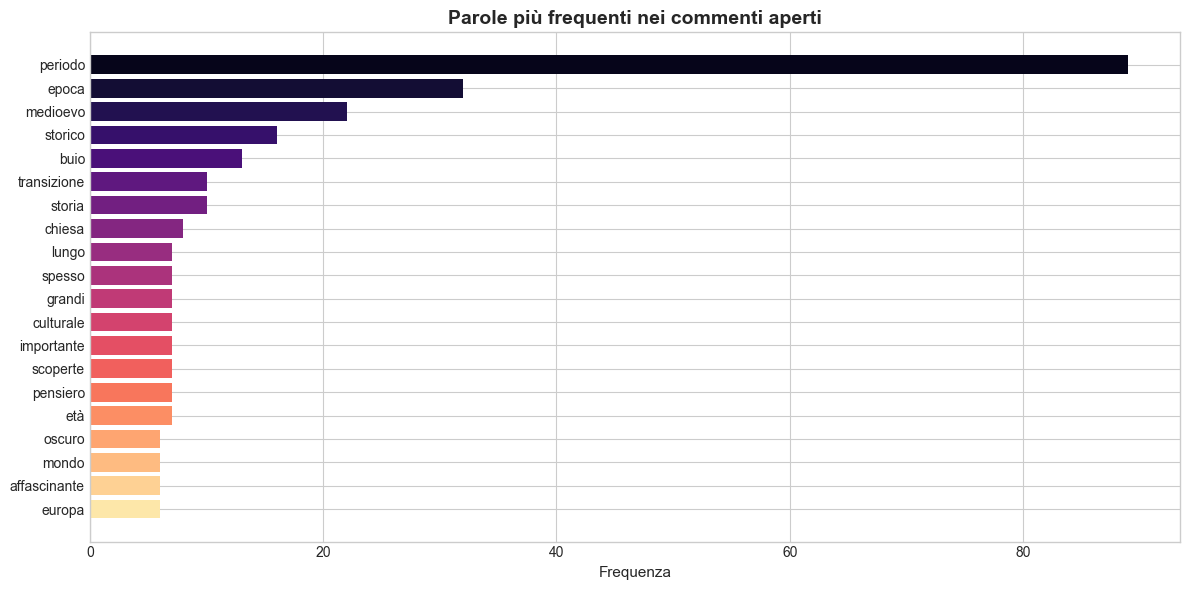

In [13]:
# Analisi delle parole chiave nei commenti
# Stopwords italiane comuni
stopwords_it = set([
    'il', 'lo', 'la', 'i', 'gli', 'le', 'un', 'uno', 'una', 'di', 'a', 'da', 'in', 'con', 'su', 'per',
    'tra', 'fra', 'e', 'o', 'ma', 'che', 'non', 'è', 'sono', 'era', 'erano', 'sia', 'come', 'anche',
    'molto', 'più', 'questo', 'questa', 'quello', 'quella', 'suo', 'sua', 'loro', 'del', 'della',
    'dei', 'delle', 'al', 'alla', 'ai', 'alle', 'dal', 'dalla', 'nel', 'nella', 'sul', 'sulla',
    'stato', 'stata', 'stati', 'essere', 'hanno', 'ha', 'ho', 'si', 'se', 'così', 'dove', 'quando',
    'poi', 'ancora', 'già', 'solo', 'ogni', 'sempre', 'mai', 'tutto', 'tutti', 'nulla', 'chi',
    'perché', 'cosa', 'cui', 'quanto', 'quale', 'quali', 'però', 'quindi', 'dopo', 'prima', 'senza',
    'verso', 'durante', 'fino', 'invece', 'proprio', 'stesso', 'altra', 'altre', 'altri', 'altro',
    'mio', 'mia', 'tuo', 'tua', 'nostro', 'nostra', 'vostro', 'vostra', 'penso', 'credo', 'secondo',
    'me', 'te', 'lui', 'lei', 'noi', 'voi', 'essi', 'esse', 'dell'
])

def estrai_parole(testo, stopwords):
    """Estrae parole significative da un testo"""
    if pd.isna(testo):
        return []
    # Rimuovi punteggiatura e converti in minuscolo
    testo = re.sub(r'[^\w\s]', ' ', str(testo).lower())
    parole = testo.split()
    # Filtra stopwords e parole corte
    return [p for p in parole if p not in stopwords and len(p) > 2]

# Conta tutte le parole
parole_counter = Counter()
for commento in commenti:
    parole_counter.update(estrai_parole(commento, stopwords_it))

print("=" * 60)
print("🔤 PAROLE PIÙ FREQUENTI NEI COMMENTI")
print("=" * 60)

top_parole = parole_counter.most_common(30)
print("\n🏆 Top 30 parole:")
for i, (parola, count) in enumerate(top_parole, 1):
    print(f"   {i:2d}. {parola}: {count}")

# Visualizzazione wordcloud-style
fig, ax = plt.subplots(figsize=(12, 6))
parole_top = top_parole[:20]
parole_names = [p[0] for p in parole_top]
parole_counts = [p[1] for p in parole_top]

colors = sns.color_palette("magma", len(parole_names))
bars = ax.barh(parole_names[::-1], parole_counts[::-1], color=colors[::-1])
ax.set_xlabel('Frequenza', fontsize=11)
ax.set_title('Parole più frequenti nei commenti aperti', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [14]:
# Sentiment Analysis semplice basata su dizionario
# Dizionari di parole positive e negative per il contesto medioevo

parole_positive = [
    'affascinante', 'interessante', 'importante', 'ricco', 'fondamentale', 'bello',
    'progresso', 'sviluppo', 'rinascita', 'innovazione', 'crescita', 'positivo',
    'grandioso', 'magnifico', 'splendido', 'meraviglioso', 'straordinario',
    'sottovalutato', 'complesso', 'variegato', 'dinamico', 'fertile', 'vitale'
]

parole_negative = [
    'buio', 'oscuro', 'negativo', 'arretrato', 'violento', 'brutale', 'ignoranza',
    'decadenza', 'superstizione', 'oppressione', 'paura', 'morte', 'guerra',
    'povero', 'miseria', 'sofferenza', 'barbaro', 'crudele', 'terribile'
]

parole_neutrali = [
    'transizione', 'passaggio', 'cambiamento', 'periodo', 'epoca', 'storia',
    'tempo', 'fase', 'evoluzione'
]

def calcola_sentiment(testo):
    """Calcola un sentiment score per il commento"""
    if pd.isna(testo):
        return None
    
    testo = str(testo).lower()
    score_pos = sum(1 for p in parole_positive if p in testo)
    score_neg = sum(1 for p in parole_negative if p in testo)
    
    # Score da -1 (molto negativo) a +1 (molto positivo)
    total = score_pos + score_neg
    if total == 0:
        return 0
    return (score_pos - score_neg) / total

def classifica_sentiment(score):
    """Classifica il sentiment"""
    if score is None:
        return 'Non classificabile'
    if score > 0.3:
        return 'Positivo'
    elif score < -0.3:
        return 'Negativo'
    else:
        return 'Neutrale/Misto'

# Applica sentiment analysis
df['sentiment_score'] = df['commento_aperto'].apply(calcola_sentiment)
df['sentiment_class'] = df['sentiment_score'].apply(classifica_sentiment)

print("=" * 60)
print("😊 SENTIMENT ANALYSIS COMMENTI")
print("=" * 60)

# Chi ha commentato
commentatori = df[df['commento_aperto'].notna()]

print(f"\n📊 Distribuzione Sentiment (n={len(commentatori)}):")
sentiment_counts = commentatori['sentiment_class'].value_counts()
for sent, count in sentiment_counts.items():
    pct = count / len(commentatori) * 100
    emoji = '😊' if sent == 'Positivo' else ('😔' if sent == 'Negativo' else '😐')
    print(f"   {emoji} {sent}: {count} ({pct:.1f}%)")

# Media sentiment score
valid_sentiment = commentatori['sentiment_score'].dropna()
print(f"\n📈 Sentiment Score medio: {valid_sentiment.mean():.3f}")
print(f"   (Range: -1 = molto negativo, +1 = molto positivo)")

😊 SENTIMENT ANALYSIS COMMENTI

📊 Distribuzione Sentiment (n=157):
   😐 Neutrale/Misto: 107 (68.2%)
   😔 Negativo: 26 (16.6%)
   😊 Positivo: 24 (15.3%)

📈 Sentiment Score medio: -0.008
   (Range: -1 = molto negativo, +1 = molto positivo)


🏷️ TEMI PRINCIPALI NEI COMMENTI
   Transizione/Passaggio: 38 commenti (24.2%)
   Periodo buio/oscuro: 19 commenti (12.1%)
   Religione/Chiesa: 11 commenti (7.0%)
   Affascinante: 8 commenti (5.1%)
   Progresso/Innovazione: 8 commenti (5.1%)
   Sottovalutato: 4 commenti (2.5%)
   Violenza/Guerra: 4 commenti (2.5%)


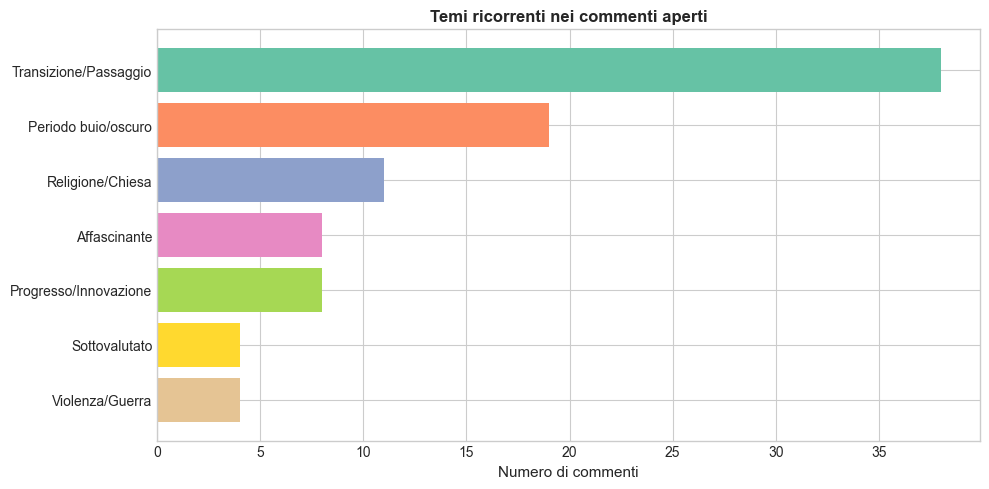

In [15]:
# Clustering tematico dei commenti
temi_commenti = {
    'Periodo buio/oscuro': ['buio', 'oscuro', 'dark', 'tenebre', 'negativo'],
    'Transizione/Passaggio': ['transizione', 'passaggio', 'ponte', 'mezzo', 'tra'],
    'Sottovalutato': ['sottovalutato', 'sottostimato', 'incompreso', 'male interpretato', 'stereotipo'],
    'Affascinante': ['affascinante', 'interessante', 'curioso', 'bello', 'magnifico'],
    'Religione/Chiesa': ['chiesa', 'religione', 'cristiano', 'cristiana', 'fede', 'papa'],
    'Progresso/Innovazione': ['progresso', 'innovazione', 'sviluppo', 'crescita', 'invenzioni'],
    'Violenza/Guerra': ['guerra', 'violento', 'crudele', 'brutale', 'sangue', 'morte']
}

def trova_tema(testo, temi_dict):
    """Identifica i temi presenti nel commento"""
    if pd.isna(testo):
        return []
    testo = str(testo).lower()
    temi_trovati = []
    for tema, keywords in temi_dict.items():
        if any(kw in testo for kw in keywords):
            temi_trovati.append(tema)
    return temi_trovati

df['temi_commento'] = df['commento_aperto'].apply(lambda x: trova_tema(x, temi_commenti))

# Conta i temi
tema_counter = Counter()
for temi in df['temi_commento'].dropna():
    tema_counter.update(temi)

print("=" * 60)
print("🏷️ TEMI PRINCIPALI NEI COMMENTI")
print("=" * 60)

for tema, count in tema_counter.most_common():
    n_commenti = len(df[df['commento_aperto'].notna()])
    pct = count / n_commenti * 100 if n_commenti > 0 else 0
    print(f"   {tema}: {count} commenti ({pct:.1f}%)")

# Visualizzazione
if tema_counter:
    fig, ax = plt.subplots(figsize=(10, 5))
    temi_sorted = tema_counter.most_common()
    temi_names = [t[0] for t in temi_sorted]
    temi_counts = [t[1] for t in temi_sorted]
    
    colors = sns.color_palette("Set2", len(temi_names))
    ax.barh(temi_names[::-1], temi_counts[::-1], color=colors[::-1])
    ax.set_xlabel('Numero di commenti', fontsize=11)
    ax.set_title('Temi ricorrenti nei commenti aperti', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 3. Analisi per Titolo di Studio e Corso di Storia Medievale
Come variano le risposte testuali in base al livello di istruzione? E come influisce l'aver frequentato un corso universitario di storia medievale?

Questa sezione replica le analisi generali suddividendole per:
- **Titolo di studio** (dal diploma alla laurea/dottorato)
- **Frequenza di un corso di storia medievale** (Sì/No)

Sottosezioni previste:
- Date e clustering per titolo di studio
- Motivazioni per titolo di studio
- Risposte aperte e sentiment per titolo di studio

📚 DATE MEDIOEVO PER TITOLO DI STUDIO

🎓 Licenza media (n=29):
   Inizio → media: 682, mediana: 500
   Fine   → media: 1464, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (59%)
   Cluster fine più comune:   1454-1492 (Scoperta America) (45%)

🎓 Diploma di istruzione professionale (n=24):
   Inizio → media: 701, mediana: 500
   Fine   → media: 1461, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (54%)
   Cluster fine più comune:   1000-1400 (Fine anticipata) (29%)

🎓 Diploma di istruzione tecnica (n=58):
   Inizio → media: 651, mediana: 480
   Fine   → media: 1421, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (52%)
   Cluster fine più comune:   1454-1492 (Scoperta America) (40%)

🎓 Diploma di istruzione liceale (n=74):
   Inizio → media: 539, mediana: 476
   Fine   → media: 1470, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (72%)
   Cluster fine più com

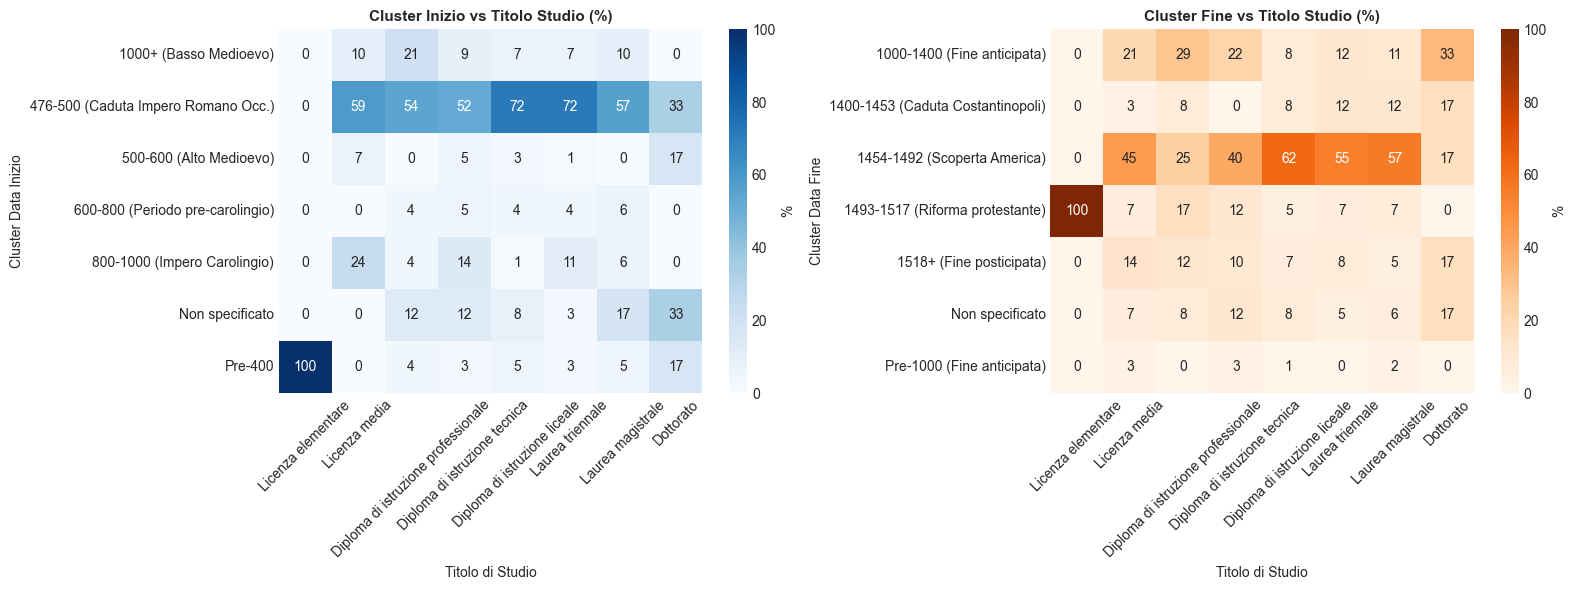

In [16]:
# ============================================================
# 3.1  DATE E CLUSTERING PER TITOLO DI STUDIO + CORSO
# ============================================================

titolo_order = ['Licenza elementare', 'Licenza media',
                'Diploma di istruzione professionale', 'Diploma di istruzione tecnica',
                'Diploma di istruzione liceale', 'Laurea triennale',
                'Laurea magistrale', 'Dottorato']

print("=" * 70)
print("📚 DATE MEDIOEVO PER TITOLO DI STUDIO")
print("=" * 70)

for titolo in titolo_order:
    subset = df[df['titolo_studio'] == titolo]
    if len(subset) < 3:
        continue
    valid_ini = subset['anno_inizio'].dropna()
    valid_fin = subset['anno_fine'].dropna()
    print(f"\n🎓 {titolo} (n={len(subset)}):")
    if len(valid_ini) > 0:
        print(f"   Inizio → media: {valid_ini.mean():.0f}, mediana: {valid_ini.median():.0f}")
    if len(valid_fin) > 0:
        print(f"   Fine   → media: {valid_fin.mean():.0f}, mediana: {valid_fin.median():.0f}")
    # Cluster più frequente
    if len(valid_ini) > 0:
        top_cl_ini = subset['cluster_inizio'].value_counts().index[0]
        pct_cl_ini = subset['cluster_inizio'].value_counts(normalize=True).iloc[0] * 100
        print(f"   Cluster inizio più comune: {top_cl_ini} ({pct_cl_ini:.0f}%)")
    if len(valid_fin) > 0:
        top_cl_fin = subset['cluster_fine'].value_counts().index[0]
        pct_cl_fin = subset['cluster_fine'].value_counts(normalize=True).iloc[0] * 100
        print(f"   Cluster fine più comune:   {top_cl_fin} ({pct_cl_fin:.0f}%)")

print(f"\n{'='*70}")
print("🎓 DATE MEDIOEVO PER CORSO DI STORIA MEDIEVALE")
print("=" * 70)

for corso in ['Sì', 'No']:
    subset = df[df['corso_medievale'] == corso]
    valid_ini = subset['anno_inizio'].dropna()
    valid_fin = subset['anno_fine'].dropna()
    print(f"\n📖 Corso medievale: {corso} (n={len(subset)}):")
    if len(valid_ini) > 0:
        print(f"   Inizio → media: {valid_ini.mean():.0f}, mediana: {valid_ini.median():.0f}")
    if len(valid_fin) > 0:
        print(f"   Fine   → media: {valid_fin.mean():.0f}, mediana: {valid_fin.median():.0f}")
    top_cl_ini = subset['cluster_inizio'].value_counts().index[0]
    pct_cl_ini = subset['cluster_inizio'].value_counts(normalize=True).iloc[0] * 100
    top_cl_fin = subset['cluster_fine'].value_counts().index[0]
    pct_cl_fin = subset['cluster_fine'].value_counts(normalize=True).iloc[0] * 100
    print(f"   Cluster inizio più comune: {top_cl_ini} ({pct_cl_ini:.0f}%)")
    print(f"   Cluster fine più comune:   {top_cl_fin} ({pct_cl_fin:.0f}%)")

# --- Heatmap: cluster vs titolo studio ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster inizio vs Titolo studio
ct_ini = pd.crosstab(df['cluster_inizio'], df['titolo_studio'], normalize='columns') * 100
cols_present = [c for c in titolo_order if c in ct_ini.columns]
if cols_present:
    ct_ini = ct_ini[cols_present]
    sns.heatmap(ct_ini, annot=True, fmt='.0f', cmap='Blues', ax=axes[0], cbar_kws={'label': '%'})
    axes[0].set_title('Cluster Inizio vs Titolo Studio (%)', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Titolo di Studio')
    axes[0].set_ylabel('Cluster Data Inizio')
    axes[0].tick_params(axis='x', rotation=45)

# Cluster fine vs Titolo studio
ct_fin = pd.crosstab(df['cluster_fine'], df['titolo_studio'], normalize='columns') * 100
cols_present = [c for c in titolo_order if c in ct_fin.columns]
if cols_present:
    ct_fin = ct_fin[cols_present]
    sns.heatmap(ct_fin, annot=True, fmt='.0f', cmap='Oranges', ax=axes[1], cbar_kws={'label': '%'})
    axes[1].set_title('Cluster Fine vs Titolo Studio (%)', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Titolo di Studio')
    axes[1].set_ylabel('Cluster Data Fine')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

📖 MOTIVAZIONI PER TITOLO DI STUDIO

🎓 Licenza media (n=29):
   Motivazioni INIZIO:
      Caduta Roma: 15 (51.7%)
      Non specificato: 7 (24.1%)
      Altro: 6 (20.7%)
   Motivazioni FINE:
      Scoperta America: 15 (51.7%)
      Altro: 7 (24.1%)
      Non specificato: 6 (20.7%)

🎓 Diploma di istruzione professionale (n=24):
   Motivazioni INIZIO:
      Caduta Roma: 9 (37.5%)
      Non specificato: 7 (29.2%)
      Altro: 5 (20.8%)
   Motivazioni FINE:
      Scoperta America: 8 (33.3%)
      Non specificato: 7 (29.2%)
      Altro: 6 (25.0%)

🎓 Diploma di istruzione tecnica (n=58):
   Motivazioni INIZIO:
      Caduta Roma: 25 (43.1%)
      Non specificato: 15 (25.9%)
      Altro: 10 (17.2%)
   Motivazioni FINE:
      Scoperta America: 24 (41.4%)
      Non specificato: 16 (27.6%)
      Altro: 11 (19.0%)

🎓 Diploma di istruzione liceale (n=74):
   Motivazioni INIZIO:
      Caduta Roma: 46 (62.2%)
      Non specificato: 14 (18.9%)
      Altro: 9 (12.2%)
   Motivazioni FINE:
      Scoperta 

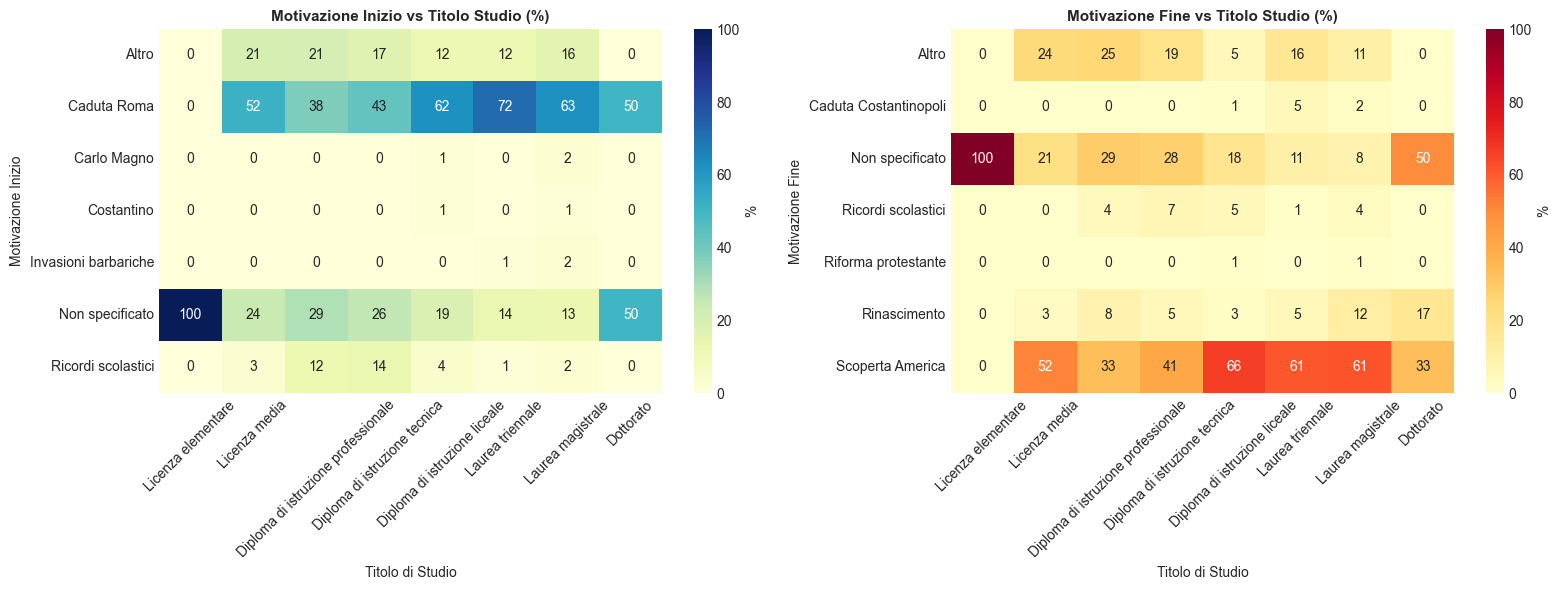

In [17]:
# ============================================================
# 3.2  MOTIVAZIONI PER TITOLO DI STUDIO + CORSO
# ============================================================

print("=" * 70)
print("📖 MOTIVAZIONI PER TITOLO DI STUDIO")
print("=" * 70)

for titolo in titolo_order:
    subset = df[df['titolo_studio'] == titolo]
    if len(subset) < 3:
        continue
    print(f"\n🎓 {titolo} (n={len(subset)}):")
    
    # Motivazione inizio
    mot_ini = subset['motivo_inizio_cat'].value_counts()
    print(f"   Motivazioni INIZIO:")
    for motivo, count in mot_ini.head(3).items():
        pct = count / len(subset) * 100
        print(f"      {motivo}: {count} ({pct:.1f}%)")
    
    # Motivazione fine
    mot_fin = subset['motivo_fine_cat'].value_counts()
    print(f"   Motivazioni FINE:")
    for motivo, count in mot_fin.head(3).items():
        pct = count / len(subset) * 100
        print(f"      {motivo}: {count} ({pct:.1f}%)")

print(f"\n{'='*70}")
print("📖 MOTIVAZIONI PER CORSO DI STORIA MEDIEVALE")
print("=" * 70)

for corso in ['Sì', 'No']:
    subset = df[df['corso_medievale'] == corso]
    print(f"\n📖 Corso: {corso} (n={len(subset)}):")
    
    mot_ini = subset['motivo_inizio_cat'].value_counts()
    print(f"   Motivazioni INIZIO:")
    for motivo, count in mot_ini.items():
        pct = count / len(subset) * 100
        print(f"      {motivo}: {count} ({pct:.1f}%)")
    
    mot_fin = subset['motivo_fine_cat'].value_counts()
    print(f"   Motivazioni FINE:")
    for motivo, count in mot_fin.items():
        pct = count / len(subset) * 100
        print(f"      {motivo}: {count} ({pct:.1f}%)")

# --- Heatmap motivazioni vs titolo studio ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ct_mot_ini = pd.crosstab(df['motivo_inizio_cat'], df['titolo_studio'], normalize='columns') * 100
cols_present = [c for c in titolo_order if c in ct_mot_ini.columns]
if cols_present:
    ct_mot_ini = ct_mot_ini[cols_present]
    sns.heatmap(ct_mot_ini, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0], cbar_kws={'label': '%'})
    axes[0].set_title('Motivazione Inizio vs Titolo Studio (%)', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Titolo di Studio')
    axes[0].set_ylabel('Motivazione Inizio')
    axes[0].tick_params(axis='x', rotation=45)

ct_mot_fin = pd.crosstab(df['motivo_fine_cat'], df['titolo_studio'], normalize='columns') * 100
cols_present = [c for c in titolo_order if c in ct_mot_fin.columns]
if cols_present:
    ct_mot_fin = ct_mot_fin[cols_present]
    sns.heatmap(ct_mot_fin, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '%'})
    axes[1].set_title('Motivazione Fine vs Titolo Studio (%)', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Titolo di Studio')
    axes[1].set_ylabel('Motivazione Fine')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

🔍 COERENZA DATA ↔ MOTIVAZIONE PER TITOLO DI STUDIO


,Titolo,n,INI: Entrambi OK,INI: Solo Data,INI: Solo Motiv,INI: Nessuno,FIN: Entrambi OK,FIN: Solo Data,FIN: Solo Motiv,FIN: Nessuno
0,Licenza media,29,13 (45%),4 (14%),2 (7%),10 (34%),12 (41%),2 (7%),3 (10%),12 (41%)
1,Diploma di istruzione professi,24,8 (33%),5 (21%),1 (4%),10 (42%),5 (21%),3 (12%),3 (12%),13 (54%)
2,Diploma di istruzione tecnica,58,19 (33%),11 (19%),6 (10%),22 (38%),19 (33%),4 (7%),5 (9%),30 (52%)
3,Diploma di istruzione liceale,74,43 (58%),10 (14%),3 (4%),18 (24%),43 (58%),9 (12%),7 (9%),15 (20%)
4,Laurea triennale,74,48 (65%),5 (7%),5 (7%),16 (22%),47 (64%),3 (4%),2 (3%),22 (30%)
5,Laurea magistrale,83,37 (45%),10 (12%),15 (18%),21 (25%),49 (59%),8 (10%),4 (5%),22 (27%)
6,Dottorato,6,2 (33%),0 (0%),1 (17%),3 (50%),2 (33%),0 (0%),0 (0%),4 (67%)



🔍 COERENZA DATA ↔ MOTIVAZIONE PER CORSO DI STORIA MEDIEVALE

📖 Corso medievale: Sì (n=83)
   INIZIO → Entrambi OK: 48 (57.8%), Solo data: 8 (9.6%), Solo motiv: 7 (8.4%)
   FINE   → Entrambi OK: 58 (69.9%), Solo data: 9 (10.8%), Solo motiv: 3 (3.6%)

📖 Corso medievale: No (n=266)
   INIZIO → Entrambi OK: 122 (45.9%), Solo data: 37 (13.9%), Solo motiv: 26 (9.8%)
   FINE   → Entrambi OK: 119 (44.7%), Solo data: 20 (7.5%), Solo motiv: 21 (7.9%)


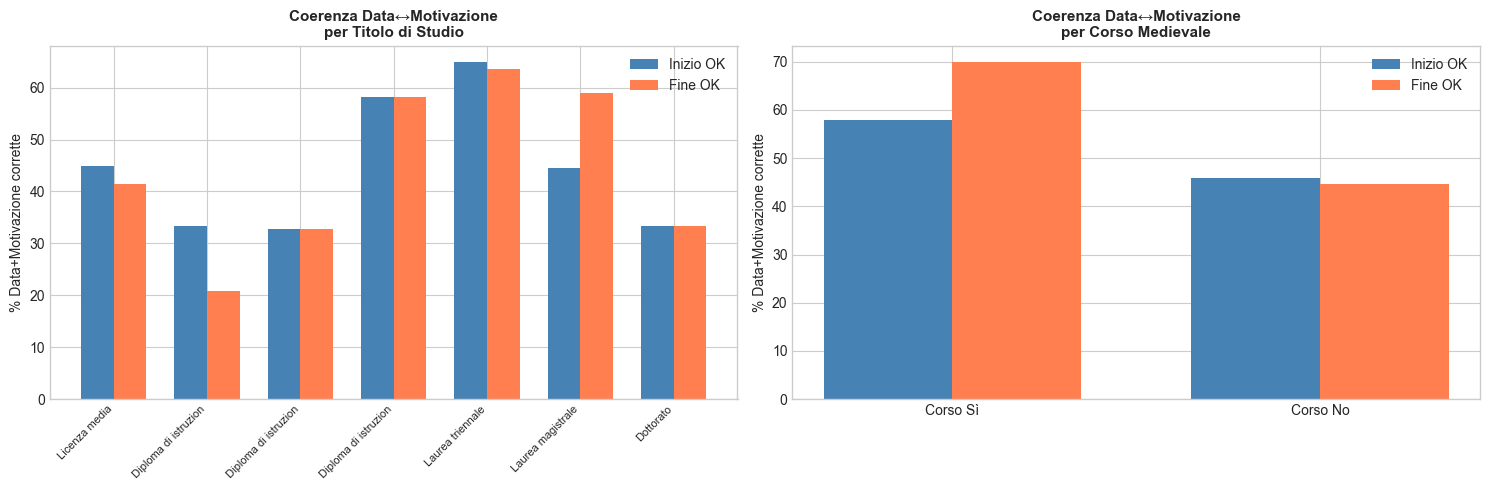

In [18]:
# ============================================================
# 3.3  COERENZA DATA ↔ MOTIVAZIONE PER TITOLO DI STUDIO + CORSO
# ============================================================

print("=" * 70)
print("🔍 COERENZA DATA ↔ MOTIVAZIONE PER TITOLO DI STUDIO")
print("=" * 70)

rows_titolo = []
for titolo in titolo_order:
    s = df[df['titolo_studio'] == titolo]
    if len(s) < 3:
        continue
    n_t = len(s)
    
    # Inizio
    d_ok_i = s['cluster_inizio'] == '476-500 (Caduta Impero Romano Occ.)'
    m_ok_i = s['motivo_inizio_cat'] == 'Caduta Roma'
    both_i = (d_ok_i & m_ok_i).sum()
    only_d_i = (d_ok_i & ~m_ok_i).sum()
    only_m_i = (~d_ok_i & m_ok_i).sum()
    none_i = (~d_ok_i & ~m_ok_i).sum()
    
    # Fine
    d_ok_f = (s['cluster_fine'] == '1454-1492 (Scoperta America)') | (s['cluster_fine'] == '1400-1453 (Caduta Costantinopoli)')
    m_ok_f = (s['motivo_fine_cat'] == 'Scoperta America') | (s['motivo_fine_cat'] == 'Caduta Costantinopoli')
    both_f = (d_ok_f & m_ok_f).sum()
    only_d_f = (d_ok_f & ~m_ok_f).sum()
    only_m_f = (~d_ok_f & m_ok_f).sum()
    none_f = (~d_ok_f & ~m_ok_f).sum()
    
    rows_titolo.append({
        'Titolo': titolo[:30],
        'n': n_t,
        'INI: Entrambi OK': f"{both_i} ({both_i/n_t*100:.0f}%)",
        'INI: Solo Data': f"{only_d_i} ({only_d_i/n_t*100:.0f}%)",
        'INI: Solo Motiv': f"{only_m_i} ({only_m_i/n_t*100:.0f}%)",
        'INI: Nessuno': f"{none_i} ({none_i/n_t*100:.0f}%)",
        'FIN: Entrambi OK': f"{both_f} ({both_f/n_t*100:.0f}%)",
        'FIN: Solo Data': f"{only_d_f} ({only_d_f/n_t*100:.0f}%)",
        'FIN: Solo Motiv': f"{only_m_f} ({only_m_f/n_t*100:.0f}%)",
        'FIN: Nessuno': f"{none_f} ({none_f/n_t*100:.0f}%)",
    })

df_coerenza_titolo = pd.DataFrame(rows_titolo)
display(df_coerenza_titolo)

print(f"\n{'='*70}")
print("🔍 COERENZA DATA ↔ MOTIVAZIONE PER CORSO DI STORIA MEDIEVALE")
print("=" * 70)

rows_corso = []
for corso in ['Sì', 'No']:
    s = df[df['corso_medievale'] == corso]
    n_c = len(s)
    
    d_ok_i = s['cluster_inizio'] == '476-500 (Caduta Impero Romano Occ.)'
    m_ok_i = s['motivo_inizio_cat'] == 'Caduta Roma'
    both_i = (d_ok_i & m_ok_i).sum()
    only_d_i = (d_ok_i & ~m_ok_i).sum()
    only_m_i = (~d_ok_i & m_ok_i).sum()
    
    d_ok_f = (s['cluster_fine'] == '1454-1492 (Scoperta America)') | (s['cluster_fine'] == '1400-1453 (Caduta Costantinopoli)')
    m_ok_f = (s['motivo_fine_cat'] == 'Scoperta America') | (s['motivo_fine_cat'] == 'Caduta Costantinopoli')
    both_f = (d_ok_f & m_ok_f).sum()
    only_d_f = (d_ok_f & ~m_ok_f).sum()
    only_m_f = (~d_ok_f & m_ok_f).sum()
    
    print(f"\n📖 Corso medievale: {corso} (n={n_c})")
    print(f"   INIZIO → Entrambi OK: {both_i} ({both_i/n_c*100:.1f}%), Solo data: {only_d_i} ({only_d_i/n_c*100:.1f}%), Solo motiv: {only_m_i} ({only_m_i/n_c*100:.1f}%)")
    print(f"   FINE   → Entrambi OK: {both_f} ({both_f/n_c*100:.1f}%), Solo data: {only_d_f} ({only_d_f/n_c*100:.1f}%), Solo motiv: {only_m_f} ({only_m_f/n_c*100:.1f}%)")

# --- Grafico a barre raggruppato ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Per titolo di studio - solo % entrambi OK
pct_both_ini = []
pct_both_fin = []
labels_titolo = []
for titolo in titolo_order:
    s = df[df['titolo_studio'] == titolo]
    if len(s) < 3:
        continue
    labels_titolo.append(titolo[:20])
    n_t = len(s)
    d_ok_i = s['cluster_inizio'] == '476-500 (Caduta Impero Romano Occ.)'
    m_ok_i = s['motivo_inizio_cat'] == 'Caduta Roma'
    pct_both_ini.append((d_ok_i & m_ok_i).sum() / n_t * 100)
    d_ok_f = (s['cluster_fine'] == '1454-1492 (Scoperta America)') | (s['cluster_fine'] == '1400-1453 (Caduta Costantinopoli)')
    m_ok_f = (s['motivo_fine_cat'] == 'Scoperta America') | (s['motivo_fine_cat'] == 'Caduta Costantinopoli')
    pct_both_fin.append((d_ok_f & m_ok_f).sum() / n_t * 100)

x = np.arange(len(labels_titolo))
w = 0.35
axes[0].bar(x - w/2, pct_both_ini, w, label='Inizio OK', color='steelblue')
axes[0].bar(x + w/2, pct_both_fin, w, label='Fine OK', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels_titolo, rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('% Data+Motivazione corrette')
axes[0].set_title('Coerenza Data↔Motivazione\nper Titolo di Studio', fontsize=11, fontweight='bold')
axes[0].legend()

# Per corso medievale
corso_labels = ['Sì', 'No']
pct_corso_ini = []
pct_corso_fin = []
for corso in corso_labels:
    s = df[df['corso_medievale'] == corso]
    n_c = len(s)
    d_ok_i = s['cluster_inizio'] == '476-500 (Caduta Impero Romano Occ.)'
    m_ok_i = s['motivo_inizio_cat'] == 'Caduta Roma'
    pct_corso_ini.append((d_ok_i & m_ok_i).sum() / n_c * 100)
    d_ok_f = (s['cluster_fine'] == '1454-1492 (Scoperta America)') | (s['cluster_fine'] == '1400-1453 (Caduta Costantinopoli)')
    m_ok_f = (s['motivo_fine_cat'] == 'Scoperta America') | (s['motivo_fine_cat'] == 'Caduta Costantinopoli')
    pct_corso_fin.append((d_ok_f & m_ok_f).sum() / n_c * 100)

x2 = np.arange(len(corso_labels))
axes[1].bar(x2 - w/2, pct_corso_ini, w, label='Inizio OK', color='steelblue')
axes[1].bar(x2 + w/2, pct_corso_fin, w, label='Fine OK', color='coral')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Corso Sì', 'Corso No'])
axes[1].set_ylabel('% Data+Motivazione corrette')
axes[1].set_title('Coerenza Data↔Motivazione\nper Corso Medievale', fontsize=11, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

💬 SENTIMENT E TEMI COMMENTI PER TITOLO DI STUDIO

🎓 Licenza media (commenti: 8):
   Sentiment medio: 0.250
   😐 Neutrale/Misto: 6 (75.0%)
   😊 Positivo: 2 (25.0%)
   Parole chiave: storia(2), periodo(2), medioevo(1), epoce(1), mondo(1)
   Temi: Affascinante(1)

🎓 Diploma di istruzione professionale (commenti: 7):
   Sentiment medio: 0.000
   😐 Neutrale/Misto: 5 (71.4%)
   😔 Negativo: 1 (14.3%)
   😊 Positivo: 1 (14.3%)
   Parole chiave: pensiero(5), periodo(3), invenzioni(2), grandi(2), positivi(2)
   Temi: Progresso/Innovazione(3), Periodo buio/oscuro(1), Religione/Chiesa(1)

🎓 Diploma di istruzione tecnica (commenti: 26):
   Sentiment medio: -0.013
   😐 Neutrale/Misto: 15 (57.7%)
   😔 Negativo: 6 (23.1%)
   😊 Positivo: 5 (19.2%)
   Parole chiave: periodo(15), epoca(5), scoperte(4), storico(3), importante(3)
   Temi: Transizione/Passaggio(5), Periodo buio/oscuro(4), Affascinante(2)

🎓 Diploma di istruzione liceale (commenti: 36):
   Sentiment medio: -0.194
   😐 Neutrale/Misto: 21 (58.3

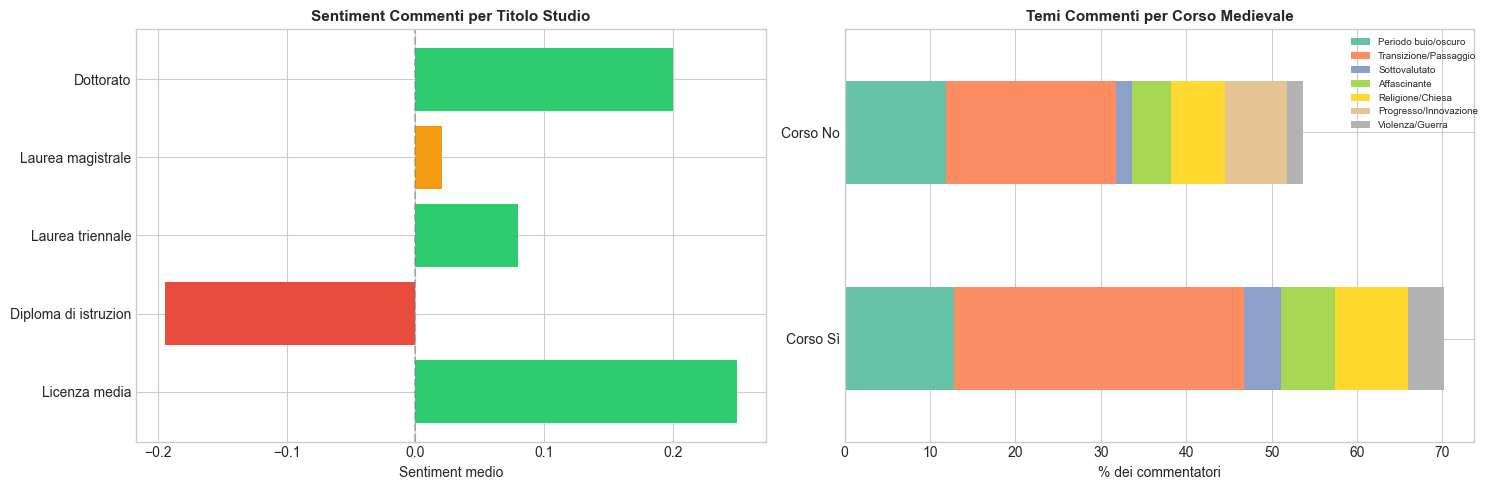

In [19]:
# ============================================================
# 3.4  RISPOSTE APERTE PER TITOLO DI STUDIO + CORSO
# ============================================================

print("=" * 70)
print("💬 SENTIMENT E TEMI COMMENTI PER TITOLO DI STUDIO")
print("=" * 70)

commentatori = df[df['commento_aperto'].notna()]

for titolo in titolo_order:
    subset = commentatori[commentatori['titolo_studio'] == titolo]
    if len(subset) < 2:
        continue
    valid_sent = subset['sentiment_score'].dropna()
    sent_dist = subset['sentiment_class'].value_counts()
    
    print(f"\n🎓 {titolo} (commenti: {len(subset)}):")
    print(f"   Sentiment medio: {valid_sent.mean():.3f}" if len(valid_sent) > 0 else "   Sentiment: N/D")
    for sent, count in sent_dist.items():
        pct = count / len(subset) * 100
        emoji = '😊' if sent == 'Positivo' else ('😔' if sent == 'Negativo' else '😐')
        print(f"   {emoji} {sent}: {count} ({pct:.1f}%)")
    
    # Top 5 parole
    parole_sub = Counter()
    for commento in subset['commento_aperto']:
        parole_sub.update(estrai_parole(commento, stopwords_it))
    top5 = parole_sub.most_common(5)
    if top5:
        print(f"   Parole chiave: {', '.join([f'{p[0]}({p[1]})' for p in top5])}")
    
    # Temi
    temi_sub = Counter()
    for temi in subset['temi_commento'].dropna():
        temi_sub.update(temi)
    if temi_sub:
        print(f"   Temi: {', '.join([f'{t[0]}({t[1]})' for t in temi_sub.most_common(3)])}")

print(f"\n{'='*70}")
print("💬 SENTIMENT E TEMI PER CORSO DI STORIA MEDIEVALE")
print("=" * 70)

for corso in ['Sì', 'No']:
    subset = commentatori[commentatori['corso_medievale'] == corso]
    valid_sent = subset['sentiment_score'].dropna()
    print(f"\n📖 Corso: {corso} (commenti: {len(subset)}):")
    print(f"   Sentiment medio: {valid_sent.mean():.3f}" if len(valid_sent) > 0 else "   Sentiment: N/D")
    sent_dist = subset['sentiment_class'].value_counts()
    for sent, count in sent_dist.items():
        pct = count / len(subset) * 100
        emoji = '😊' if sent == 'Positivo' else ('😔' if sent == 'Negativo' else '😐')
        print(f"   {emoji} {sent}: {count} ({pct:.1f}%)")
    
    parole_sub = Counter()
    for commento in subset['commento_aperto']:
        parole_sub.update(estrai_parole(commento, stopwords_it))
    top5 = parole_sub.most_common(5)
    if top5:
        print(f"   Parole chiave: {', '.join([f'{p[0]}({p[1]})' for p in top5])}")
    
    temi_sub = Counter()
    for temi in subset['temi_commento'].dropna():
        temi_sub.update(temi)
    if temi_sub:
        print(f"   Temi: {', '.join([f'{t[0]}({t[1]})' for t in temi_sub.most_common()])}")

# --- Grafico: sentiment medio per titolo di studio ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sentiment per titolo
sent_titolo = []
labels_t = []
for titolo in titolo_order:
    subset = commentatori[commentatori['titolo_studio'] == titolo]
    if len(subset) >= 2:
        labels_t.append(titolo[:20])
        sent_titolo.append(subset['sentiment_score'].dropna().mean())

colors_sent = ['#2ecc71' if s > 0.05 else ('#e74c3c' if s < -0.05 else '#f39c12') for s in sent_titolo]
axes[0].barh(labels_t, sent_titolo, color=colors_sent)
axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Sentiment medio')
axes[0].set_title('Sentiment Commenti per Titolo Studio', fontsize=11, fontweight='bold')

# Temi per corso medievale (stacked bar)
temi_keys = list(temi_commenti.keys())
corso_temi_data = {}
for corso in ['Sì', 'No']:
    subset = df[df['corso_medievale'] == corso]
    n_comm = len(subset[subset['commento_aperto'].notna()])
    tema_counts = Counter()
    for temi in subset['temi_commento'].dropna():
        tema_counts.update(temi)
    corso_temi_data[f'Corso {corso}'] = {t: (tema_counts.get(t, 0) / n_comm * 100 if n_comm > 0 else 0) for t in temi_keys}

df_temi_corso = pd.DataFrame(corso_temi_data).T
df_temi_corso.plot(kind='barh', stacked=True, ax=axes[1], colormap='Set2')
axes[1].set_xlabel('% dei commentatori')
axes[1].set_title('Temi Commenti per Corso Medievale', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=7, bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

## 4. Analisi per Sesso
Come variano le risposte testuali tra uomini e donne?

Questa sezione replica le analisi generali suddividendole per:
- **Date e clustering** per sesso
- **Motivazioni** per sesso
- **Risposte aperte e sentiment** per sesso
- **Test statistici** per verificare differenze significative

## 5. Analisi per Fascia d'Età
Come cambiano le risposte testuali nelle diverse generazioni?

Questa sezione replica le analisi generali suddividendole per:
- **Date e clustering** per fascia d'età
- **Motivazioni** per fascia d'età
- **Risposte aperte e sentiment** per fascia d'età

👥 DATE MEDIOEVO PER FASCIA D'ETÀ

👤 18-19 (n=16):
   Inizio → media: 659, mediana: 476
   Fine   → media: 1389, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (56%)
   Cluster fine più comune:   1454-1492 (Scoperta America) (50%)
   Durata media percepita: 767 anni

👤 20-29 (n=139):
   Inizio → media: 547, mediana: 476
   Fine   → media: 1484, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (78%)
   Cluster fine più comune:   1454-1492 (Scoperta America) (65%)
   Durata media percepita: 941 anni

👤 30-39 (n=40):
   Inizio → media: 698, mediana: 500
   Fine   → media: 1449, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (50%)
   Cluster fine più comune:   1454-1492 (Scoperta America) (45%)
   Durata media percepita: 770 anni

👤 40-49 (n=38):
   Inizio → media: 658, mediana: 488
   Fine   → media: 1419, mediana: 1492
   Cluster inizio più comune: 476-500 (Caduta Impero Romano Occ.) (50%)
   

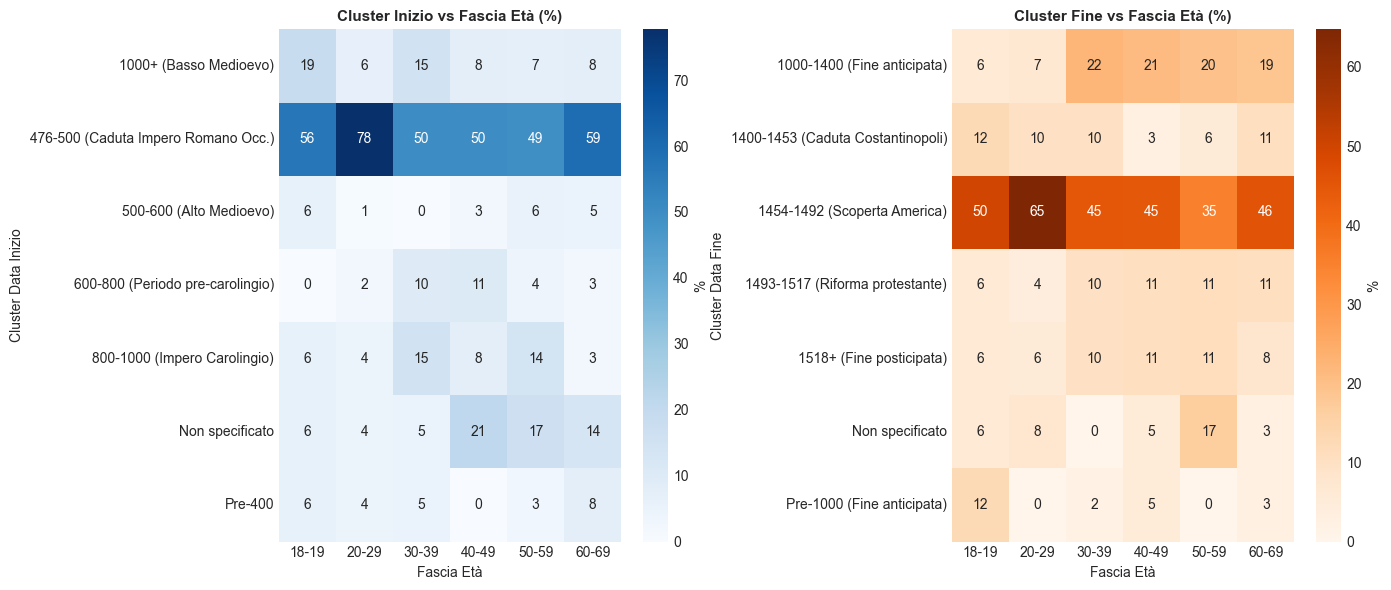

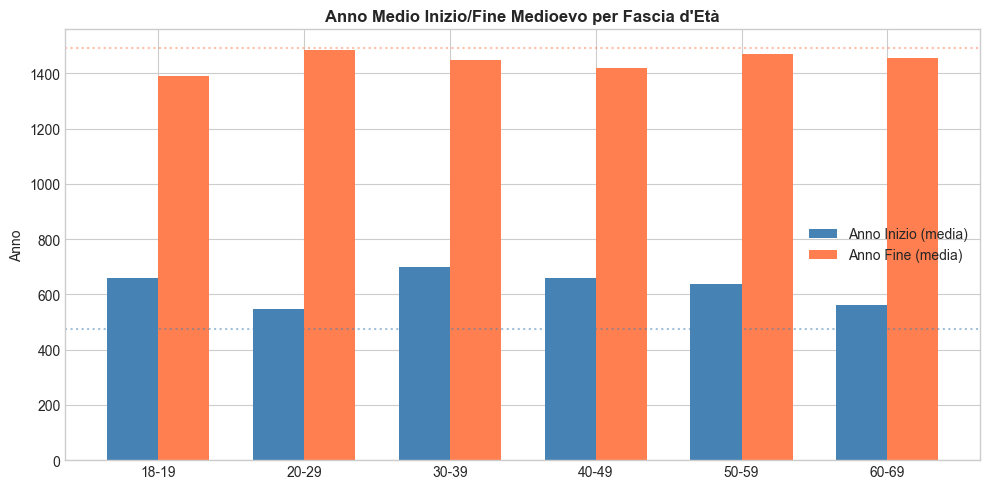

In [20]:
# ============================================================
# 5.1  DATE E CLUSTERING PER FASCIA D'ETÀ
# ============================================================

eta_order = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

print("=" * 70)
print("👥 DATE MEDIOEVO PER FASCIA D'ETÀ")
print("=" * 70)

for eta in eta_order:
    subset = df[df['eta'] == eta]
    if len(subset) < 3:
        continue
    valid_ini = subset['anno_inizio'].dropna()
    valid_fin = subset['anno_fine'].dropna()
    print(f"\n👤 {eta} (n={len(subset)}):")
    if len(valid_ini) > 0:
        print(f"   Inizio → media: {valid_ini.mean():.0f}, mediana: {valid_ini.median():.0f}")
    if len(valid_fin) > 0:
        print(f"   Fine   → media: {valid_fin.mean():.0f}, mediana: {valid_fin.median():.0f}")
    if len(valid_ini) > 0:
        top_cl_ini = subset['cluster_inizio'].value_counts().index[0]
        pct_cl_ini = subset['cluster_inizio'].value_counts(normalize=True).iloc[0] * 100
        print(f"   Cluster inizio più comune: {top_cl_ini} ({pct_cl_ini:.0f}%)")
    if len(valid_fin) > 0:
        top_cl_fin = subset['cluster_fine'].value_counts().index[0]
        pct_cl_fin = subset['cluster_fine'].value_counts(normalize=True).iloc[0] * 100
        print(f"   Cluster fine più comune:   {top_cl_fin} ({pct_cl_fin:.0f}%)")
    # Durata
    valid_dur = subset['durata_medioevo'].dropna()
    valid_dur = valid_dur[(valid_dur > 0) & (valid_dur < 2000)]
    if len(valid_dur) > 0:
        print(f"   Durata media percepita: {valid_dur.mean():.0f} anni")

# --- Heatmap: cluster vs fascia d'età ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ct_ini_eta = pd.crosstab(df['cluster_inizio'], df['eta'], normalize='columns') * 100
cols_present = [c for c in eta_order if c in ct_ini_eta.columns]
if cols_present:
    ct_ini_eta = ct_ini_eta[cols_present]
    sns.heatmap(ct_ini_eta, annot=True, fmt='.0f', cmap='Blues', ax=axes[0], cbar_kws={'label': '%'})
    axes[0].set_title('Cluster Inizio vs Fascia Età (%)', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Fascia Età')
    axes[0].set_ylabel('Cluster Data Inizio')

ct_fin_eta = pd.crosstab(df['cluster_fine'], df['eta'], normalize='columns') * 100
cols_present = [c for c in eta_order if c in ct_fin_eta.columns]
if cols_present:
    ct_fin_eta = ct_fin_eta[cols_present]
    sns.heatmap(ct_fin_eta, annot=True, fmt='.0f', cmap='Oranges', ax=axes[1], cbar_kws={'label': '%'})
    axes[1].set_title('Cluster Fine vs Fascia Età (%)', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Fascia Età')
    axes[1].set_ylabel('Cluster Data Fine')

plt.tight_layout()
plt.show()

# --- Grafico: anno medio inizio/fine per fascia d'età ---
fig, ax = plt.subplots(figsize=(10, 5))
eta_means_ini = []
eta_means_fin = []
eta_labels = []
for eta in eta_order:
    subset = df[df['eta'] == eta]
    if len(subset) < 3:
        continue
    v_ini = subset['anno_inizio'].dropna()
    v_fin = subset['anno_fine'].dropna()
    if len(v_ini) > 0 and len(v_fin) > 0:
        eta_labels.append(eta)
        eta_means_ini.append(v_ini.mean())
        eta_means_fin.append(v_fin.mean())

x = np.arange(len(eta_labels))
w = 0.35
ax.bar(x - w/2, eta_means_ini, w, label='Anno Inizio (media)', color='steelblue')
ax.bar(x + w/2, eta_means_fin, w, label='Anno Fine (media)', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(eta_labels)
ax.set_ylabel('Anno')
ax.set_title('Anno Medio Inizio/Fine Medioevo per Fascia d\'Età', fontsize=12, fontweight='bold')
ax.legend()
ax.axhline(y=476, color='steelblue', linestyle=':', alpha=0.5, label='_476')
ax.axhline(y=1492, color='coral', linestyle=':', alpha=0.5, label='_1492')
plt.tight_layout()
plt.show()

📋 MOTIVAZIONI PER FASCIA D'ETÀ

👤 18-19 (n=16):
   Inizio: dominante = 'Caduta Roma' (50%)
   Fine: dominante = 'Scoperta America' (62%)

👤 20-29 (n=139):
   Inizio: dominante = 'Caduta Roma' (72%)
   Fine: dominante = 'Scoperta America' (67%)

👤 30-39 (n=40):
   Inizio: dominante = 'Caduta Roma' (50%)
   Fine: dominante = 'Scoperta America' (57%)

👤 40-49 (n=38):
   Inizio: dominante = 'Caduta Roma' (47%)
   Fine: dominante = 'Scoperta America' (47%)

👤 50-59 (n=71):
   Inizio: dominante = 'Caduta Roma' (44%)
   Fine: dominante = 'Scoperta America' (41%)

👤 60-69 (n=37):
   Inizio: dominante = 'Caduta Roma' (62%)
   Fine: dominante = 'Scoperta America' (49%)


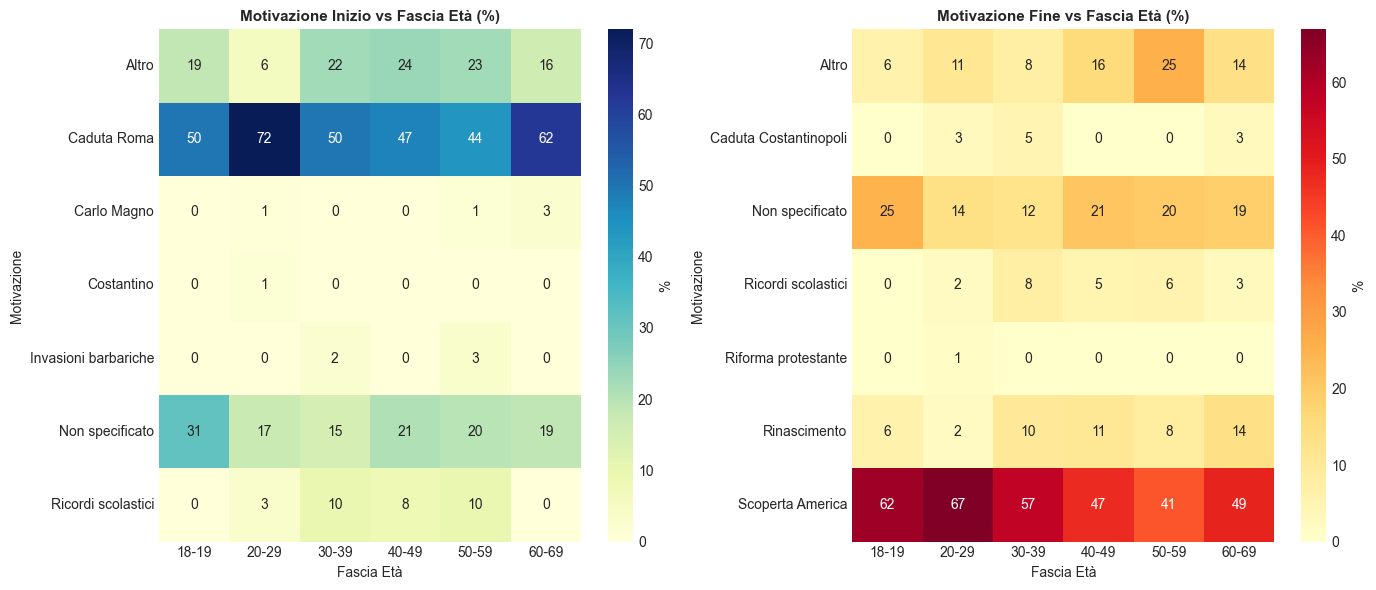

In [21]:
# ============================================================
# 5.2  MOTIVAZIONI PER FASCIA D'ETÀ
# ============================================================

print("=" * 70)
print("📋 MOTIVAZIONI PER FASCIA D'ETÀ")
print("=" * 70)

for eta in eta_order:
    subset = df[df['eta'] == eta]
    if len(subset) < 3:
        continue
    print(f"\n👤 {eta} (n={len(subset)}):")
    for label, col in [('Inizio', 'motivo_inizio_cat'), ('Fine', 'motivo_fine_cat')]:
        vc = subset[col].value_counts(normalize=True) * 100
        top = vc.index[0]
        print(f"   {label}: dominante = '{top}' ({vc.iloc[0]:.0f}%)")

# --- Heatmap motivazioni vs fascia d'età ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ct_mot_ini_e = pd.crosstab(df['motivo_inizio_cat'], df['eta'], normalize='columns') * 100
cols_e = [c for c in eta_order if c in ct_mot_ini_e.columns]
if cols_e:
    ct_mot_ini_e = ct_mot_ini_e[cols_e]
    sns.heatmap(ct_mot_ini_e, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0], cbar_kws={'label': '%'})
    axes[0].set_title('Motivazione Inizio vs Fascia Età (%)', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Fascia Età')
    axes[0].set_ylabel('Motivazione')

ct_mot_fin_e = pd.crosstab(df['motivo_fine_cat'], df['eta'], normalize='columns') * 100
cols_e = [c for c in eta_order if c in ct_mot_fin_e.columns]
if cols_e:
    ct_mot_fin_e = ct_mot_fin_e[cols_e]
    sns.heatmap(ct_mot_fin_e, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '%'})
    axes[1].set_title('Motivazione Fine vs Fascia Età (%)', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Fascia Età')
    axes[1].set_ylabel('Motivazione')

plt.tight_layout()
plt.show()

🔍 COERENZA DATA ↔ MOTIVAZIONE PER FASCIA D'ETÀ

👤 18-19 (n=16):
   ✅ Entrambi corretti:        0 (0.0%)
   📅 Solo data corretta:       0 (0.0%)
   💭 Solo motivazione corretta:   0 (0.0%)
   ❌ Nessuno corretto:        16 (100.0%)

👤 20-29 (n=139):
   ✅ Entrambi corretti:        0 (0.0%)
   📅 Solo data corretta:       0 (0.0%)
   💭 Solo motivazione corretta:   0 (0.0%)
   ❌ Nessuno corretto:       139 (100.0%)

👤 30-39 (n=40):
   ✅ Entrambi corretti:        0 (0.0%)
   📅 Solo data corretta:       0 (0.0%)
   💭 Solo motivazione corretta:   0 (0.0%)
   ❌ Nessuno corretto:        40 (100.0%)

👤 40-49 (n=38):
   ✅ Entrambi corretti:        0 (0.0%)
   📅 Solo data corretta:       0 (0.0%)
   💭 Solo motivazione corretta:   0 (0.0%)
   ❌ Nessuno corretto:        38 (100.0%)

👤 50-59 (n=71):
   ✅ Entrambi corretti:        0 (0.0%)
   📅 Solo data corretta:       0 (0.0%)
   💭 Solo motivazione corretta:   0 (0.0%)
   ❌ Nessuno corretto:        71 (100.0%)

👤 60-69 (n=37):
   ✅ Entrambi corretti:  

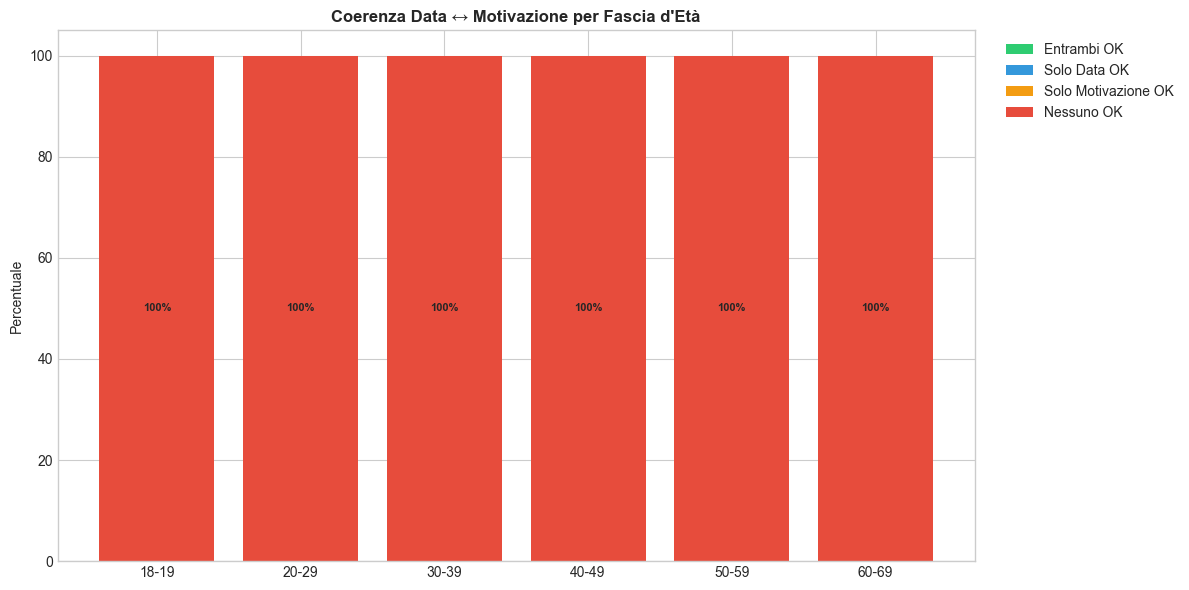

In [22]:
# ============================================================
# 5.3  COERENZA DATA ↔ MOTIVAZIONE PER FASCIA D'ETÀ
# ============================================================

print("=" * 70)
print("🔍 COERENZA DATA ↔ MOTIVAZIONE PER FASCIA D'ETÀ")
print("=" * 70)

# Cluster "corretti"
cluster_inizio_ok = {'476 d.C. (caduta Impero Romano d\'Occidente)'}
cluster_fine_ok   = {'1453 (caduta di Costantinopoli)', '1492 (scoperta dell\'America)'}

motivo_inizio_ok  = {'Caduta Impero Romano', 'Evento storico/politico'}
motivo_fine_ok    = {'Scoperta/esplorazione', 'Caduta di Costantinopoli', 'Evento storico/politico'}

results_eta = []
for eta in eta_order:
    subset = df[df['eta'] == eta].copy()
    n = len(subset)
    if n < 3:
        continue

    data_ok = subset['cluster_inizio'].isin(cluster_inizio_ok) | subset['cluster_fine'].isin(cluster_fine_ok)
    motivo_ok = subset['motivo_inizio_cat'].isin(motivo_inizio_ok) | subset['motivo_fine_cat'].isin(motivo_fine_ok)

    entrambi  = (data_ok & motivo_ok).sum()
    solo_data = (data_ok & ~motivo_ok).sum()
    solo_mot  = (~data_ok & motivo_ok).sum()
    nessuno   = (~data_ok & ~motivo_ok).sum()

    results_eta.append({
        'Fascia Età': eta, 'n': n,
        'Entrambi OK (%)': entrambi / n * 100,
        'Solo Data OK (%)': solo_data / n * 100,
        'Solo Motivazione OK (%)': solo_mot / n * 100,
        'Nessuno OK (%)': nessuno / n * 100
    })

    print(f"\n👤 {eta} (n={n}):")
    print(f"   ✅ Entrambi corretti:      {entrambi:3d} ({entrambi/n*100:.1f}%)")
    print(f"   📅 Solo data corretta:     {solo_data:3d} ({solo_data/n*100:.1f}%)")
    print(f"   💭 Solo motivazione corretta: {solo_mot:3d} ({solo_mot/n*100:.1f}%)")
    print(f"   ❌ Nessuno corretto:       {nessuno:3d} ({nessuno/n*100:.1f}%)")

# --- Grafico a barre impilate ---
if results_eta:
    df_coh_eta = pd.DataFrame(results_eta)
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df_coh_eta))
    cats = ['Entrambi OK (%)', 'Solo Data OK (%)', 'Solo Motivazione OK (%)', 'Nessuno OK (%)']
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
    bottom = np.zeros(len(df_coh_eta))
    for cat, col in zip(cats, colors):
        vals = df_coh_eta[cat].values
        ax.bar(x, vals, bottom=bottom, label=cat.replace(' (%)', ''), color=col)
        for i, (v, b) in enumerate(zip(vals, bottom)):
            if v > 5:
                ax.text(i, b + v/2, f'{v:.0f}%', ha='center', va='center', fontsize=8, fontweight='bold')
        bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(df_coh_eta['Fascia Età'], rotation=0)
    ax.set_ylabel('Percentuale')
    ax.set_title('Coerenza Data ↔ Motivazione per Fascia d\'Età', fontsize=12, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

💬 RISPOSTE APERTE PER FASCIA D'ETÀ

👤 18-19 (n=16, commenti: 5 = 31%):
   Sentiment positivo: 0%
   Sentiment neutro: 0%
   Sentiment negativo: 0%
   Temi top: Progresso/Innovazione(1), Periodo buio/oscuro(1), Religione/Chiesa(1)
   Parole top: pensiero(5), periodo(4), epoca(2), positivo(2), negativo(2)

👤 20-29 (n=139, commenti: 53 = 38%):
   Sentiment positivo: 0%
   Sentiment neutro: 0%
   Sentiment negativo: 0%
   Temi top: Transizione/Passaggio(16), Periodo buio/oscuro(8), Religione/Chiesa(8)
   Parole top: periodo(34), epoca(14), medioevo(13), spesso(7), chiesa(6)

👤 30-39 (n=40, commenti: 17 = 42%):
   Sentiment positivo: 0%
   Sentiment neutro: 0%
   Sentiment negativo: 0%
   Temi top: Transizione/Passaggio(3), Periodo buio/oscuro(2), Affascinante(2)
   Parole top: periodo(9), storico(5), storici(3), buio(2), umanità(2)

👤 40-49 (n=38, commenti: 17 = 45%):
   Sentiment positivo: 0%
   Sentiment neutro: 0%
   Sentiment negativo: 0%
   Temi top: Periodo buio/oscuro(2), Transizion

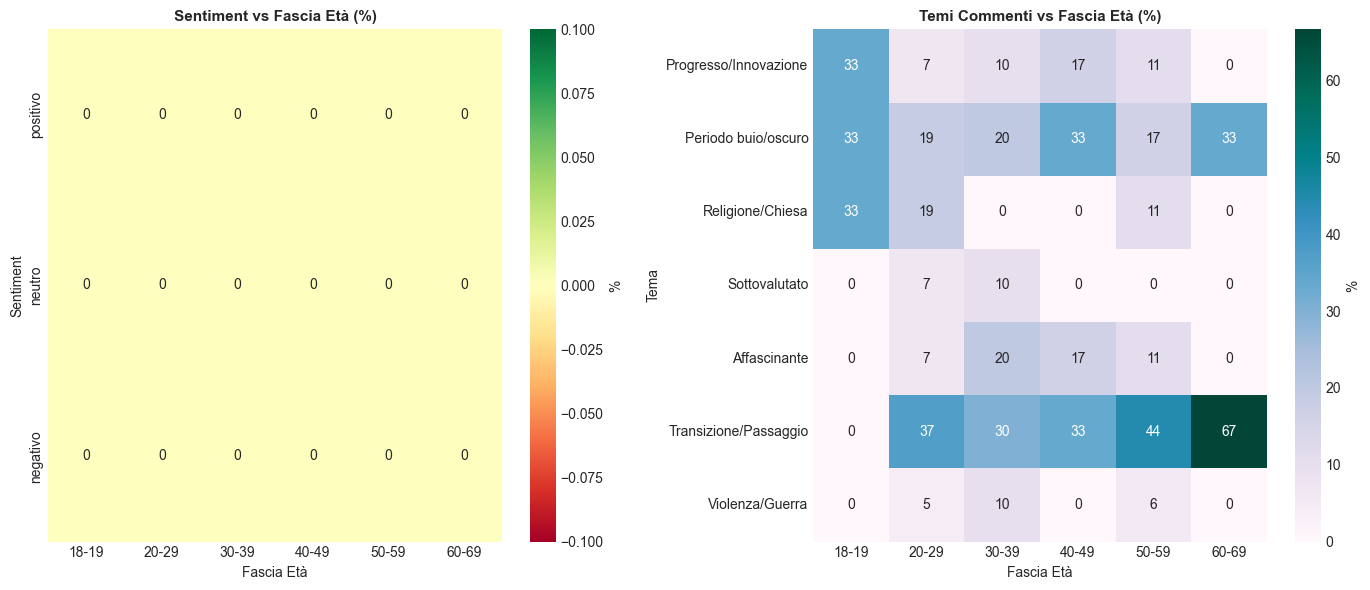

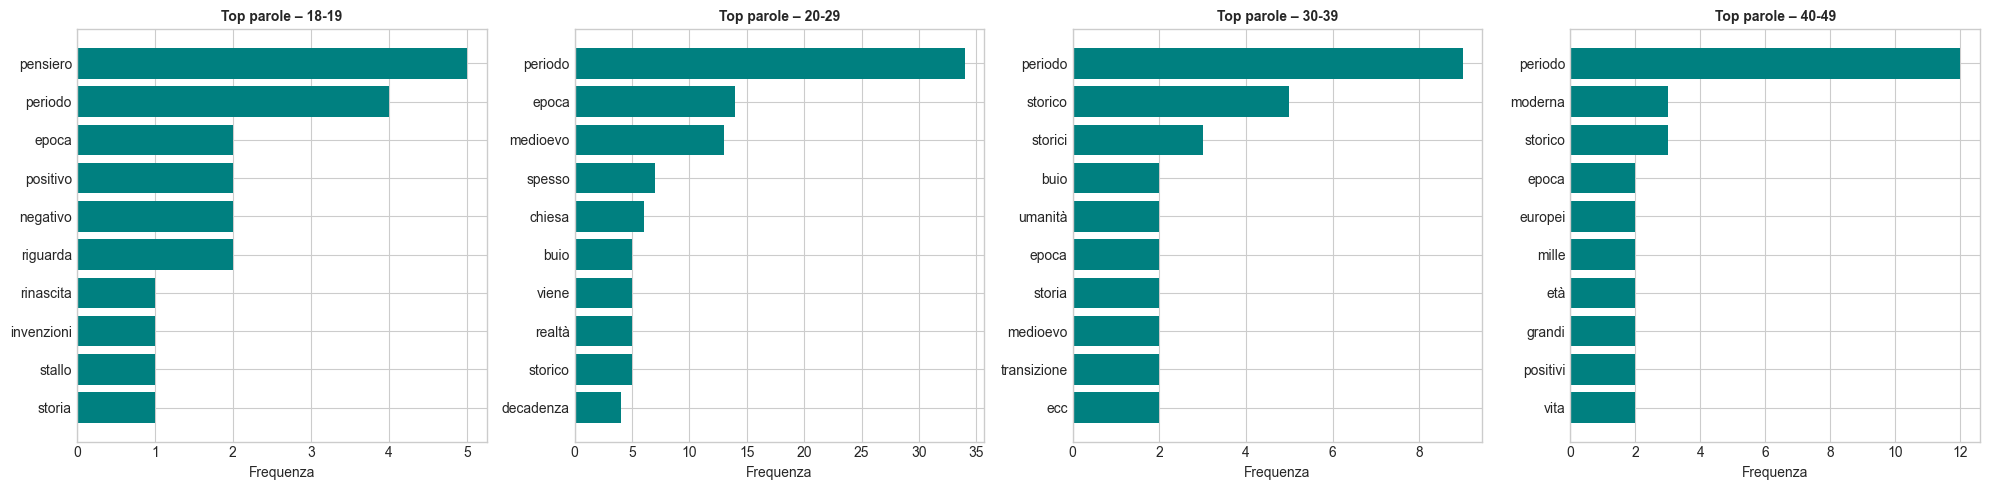

In [23]:
# ============================================================
# 5.4  SENTIMENT, TEMI E PAROLE CHIAVE PER FASCIA D'ETÀ
# ============================================================

print("=" * 70)
print("💬 RISPOSTE APERTE PER FASCIA D'ETÀ")
print("=" * 70)

for eta in eta_order:
    subset = df[df['eta'] == eta]
    if len(subset) < 3:
        continue
    comm = subset[subset['commento_aperto'].notna() & (subset['commento_aperto'].str.strip() != '')]
    n_comm = len(comm)
    pct_comm = n_comm / len(subset) * 100

    print(f"\n👤 {eta} (n={len(subset)}, commenti: {n_comm} = {pct_comm:.0f}%):")

    if n_comm > 0:
        # Sentiment
        sent_dist = comm['sentiment_class'].value_counts(normalize=True) * 100
        for s_class in ['positivo', 'neutro', 'negativo']:
            val = sent_dist.get(s_class, 0)
            print(f"   Sentiment {s_class}: {val:.0f}%")
        # Temi principali
        temi_all = []
        for t_list in comm['temi_commento'].dropna():
            if isinstance(t_list, list):
                temi_all.extend(t_list)
        if temi_all:
            top_temi = Counter(temi_all).most_common(3)
            print(f"   Temi top: {', '.join([f'{t}({c})' for t, c in top_temi])}")
        # Parole chiave
        all_words = []
        for txt in comm['commento_aperto']:
            all_words.extend(estrai_parole(txt, stopwords_it))
        if all_words:
            top_words = Counter(all_words).most_common(5)
            print(f"   Parole top: {', '.join([f'{w}({c})' for w, c in top_words])}")

# --- Grafico: sentiment per fascia d'età ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap sentiment
sent_eta = pd.crosstab(df[df['sentiment_class'].notna()]['sentiment_class'],
                        df[df['sentiment_class'].notna()]['eta'],
                        normalize='columns') * 100
cols_e = [c for c in eta_order if c in sent_eta.columns]
if cols_e:
    sent_eta = sent_eta[cols_e]
    # Riordina righe
    for s in ['positivo', 'neutro', 'negativo']:
        if s not in sent_eta.index:
            sent_eta.loc[s] = 0
    sent_eta = sent_eta.loc[[s for s in ['positivo', 'neutro', 'negativo'] if s in sent_eta.index]]
    sns.heatmap(sent_eta, annot=True, fmt='.0f', cmap='RdYlGn', ax=axes[0], cbar_kws={'label': '%'})
    axes[0].set_title('Sentiment vs Fascia Età (%)', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Fascia Età')
    axes[0].set_ylabel('Sentiment')

# Heatmap temi
temi_per_eta = {}
for eta in eta_order:
    subset = df[(df['eta'] == eta) & df['temi_commento'].notna()]
    temi_all = []
    for t_list in subset['temi_commento']:
        if isinstance(t_list, list):
            temi_all.extend(t_list)
    if temi_all:
        tc = Counter(temi_all)
        total = sum(tc.values())
        temi_per_eta[eta] = {t: c / total * 100 for t, c in tc.items()}

if temi_per_eta:
    df_temi_eta = pd.DataFrame(temi_per_eta).fillna(0)
    cols_e = [c for c in eta_order if c in df_temi_eta.columns]
    if cols_e:
        df_temi_eta = df_temi_eta[cols_e]
        sns.heatmap(df_temi_eta, annot=True, fmt='.0f', cmap='PuBuGn', ax=axes[1], cbar_kws={'label': '%'})
        axes[1].set_title('Temi Commenti vs Fascia Età (%)', fontsize=11, fontweight='bold')
        axes[1].set_xlabel('Fascia Età')
        axes[1].set_ylabel('Tema')

plt.tight_layout()
plt.show()

# --- Grafico: parole chiave più frequenti per le prime 4 fasce d'età ---
top_eta_groups = [e for e in eta_order if len(df[df['eta'] == e]) >= 3][:4]
if top_eta_groups:
    fig, axes2 = plt.subplots(1, len(top_eta_groups), figsize=(5 * len(top_eta_groups), 5))
    if len(top_eta_groups) == 1:
        axes2 = [axes2]
    for ax, eta in zip(axes2, top_eta_groups):
        comm = df[(df['eta'] == eta) & df['commento_aperto'].notna() & (df['commento_aperto'].str.strip() != '')]
        all_w = []
        for txt in comm['commento_aperto']:
            all_w.extend(estrai_parole(txt, stopwords_it))
        if all_w:
            top10 = Counter(all_w).most_common(10)
            words, counts = zip(*top10)
            ax.barh(range(len(words)), counts, color='teal')
            ax.set_yticks(range(len(words)))
            ax.set_yticklabels(words)
            ax.invert_yaxis()
        ax.set_title(f'Top parole – {eta}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Frequenza')
    plt.tight_layout()
    plt.show()

## 6. Analisi per Metodo Informativo
Come influiscono le fonti di informazione sulle risposte testuali?

Questa sezione replica le analisi generali suddividendole per modalità di informazione:
- **Date e clustering** per metodo informativo
- **Motivazioni** per metodo informativo
- **Risposte aperte e sentiment** per metodo informativo